## Complete Melanoma Classification & CBIR System

### **Implementation**:
- 4 Models: DenseNet121, InceptionV3, Xception, ViT
- Classification: Ensemble with Random Search optimization
- CBIR: Individual + Multi-model fusion

 
### **Improvements Applied**:
1. InceptionV3 BatchNorm fix
2. Random Search ensemble (2000 trials + early stop)
3. Mixup augmentation (α=0.2)
4. Label smoothing (0.1)

### SECTION 1: SETUP

#### 1.1 Installation

In [1]:
import sys
!{sys.executable} -m pip install -q tensorflow
!{sys.executable} -m pip install -q scikit-learn matplotlib seaborn opencv-python-headless pillow tqdm

print("✓ All packages installed")

✓ All packages installed


#### 1.2 Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
from datetime import datetime, timedelta
from tqdm import tqdm
from itertools import cycle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, InceptionV3, Xception

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, average_precision_score,
    cohen_kappa_score, matthews_corrcoef
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.utils import resample

# Seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"✓ TensorFlow: {tf.__version__}")
print(f"✓ Random seed: {SEED}")

2026-01-18 23:44:50.939537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768779891.277799     100 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768779891.402972     100 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768779892.277320     100 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768779892.277373     100 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768779892.277376     100 computation_placer.cc:177] computation placer alr

✓ TensorFlow: 2.19.0
✓ Random seed: 42


#### 1.3 Configuration

In [3]:
class Config:
    """Complete configuration"""
    
    # === PATHS ===
    BASE_DIR = Path('/kaggle/input/melanoma-cancer-dataset')
    TRAIN_DIR = BASE_DIR / 'train'
    TEST_DIR = BASE_DIR / 'test'
    
    OUTPUT_DIR = Path('/kaggle/working')
    MODEL_DIR = OUTPUT_DIR / 'models'
    RESULTS_DIR = OUTPUT_DIR / 'results'
    FEATURES_DIR = OUTPUT_DIR / 'features'
    FIGURES_DIR = OUTPUT_DIR / 'figures'
    
    for d in [OUTPUT_DIR, MODEL_DIR, RESULTS_DIR, FEATURES_DIR, FIGURES_DIR]:
        d.mkdir(parents=True, exist_ok=True)
    
    # === IMAGE ===
    IMG_SIZE = 224
    IMG_SIZE_INCEPTION = 299
    CHANNELS = 3
    
    # === TRAINING ===
    BATCH_SIZE = 32
    EPOCHS = 40
    LEARNING_RATE = 0.001
    PATIENCE = 10
    
    # === IMPROVEMENTS ===
    USE_LABEL_SMOOTHING = True
    LABEL_SMOOTHING = 0.1
    USE_MIXUP = True
    MIXUP_ALPHA = 0.2
    
    # === MODELS ===
    MODELS_TO_TRAIN = ['DenseNet121', 'InceptionV3', 'Xception', 'ViT']
    
    MODEL_CONFIG = {
        'DenseNet121': {
            'img_size': IMG_SIZE,
            'freeze_layers': 121,
            'optimizer': 'adamax'
        },
        'InceptionV3': {
            'img_size': IMG_SIZE_INCEPTION,
            'freeze_layers': 150,
            'optimizer': 'adam',
            'fine_tune_lr': 0.0001,
            'use_batchnorm': True
        },
        'Xception': {
            'img_size': IMG_SIZE_INCEPTION,
            'freeze_layers': 80,
            'optimizer': 'adam'
        },
        'ViT': {
            'img_size': IMG_SIZE,
            'patch_size': 16,
            'projection_dim': 64,
            'num_heads': 4,
            'transformer_layers': 8,
            'mlp_head_units': [2048, 1024]
        }
    }
    
    # === AUGMENTATION ===
    ROTATION_RANGE = 15
    WIDTH_SHIFT = 0.1
    HEIGHT_SHIFT = 0.1
    SHEAR_RANGE = 0.2
    ZOOM_RANGE = 0.1
    BRIGHTNESS_RANGE = [0.8, 1.2]
    
    # === REGULARIZATION ===
    DROPOUT_RATE = 0.5
    L2_REG = 1e-4
    
    # === ENSEMBLE ===
    RANDOM_SEARCH_TRIALS = 2000
    EARLY_STOP_PATIENCE = 100
    
    # === CBIR ===
    NUM_CBIR_QUERIES = 20
    TOP_K_RETRIEVAL = 5
    
    # === BOOTSTRAP ===
    BOOTSTRAP_ITERATIONS = 100
    
    # === CLASSES ===
    CLASSES = ['Benign', 'Malignant']
    CLASS_MODE = 'binary'
    
    # === BASELINE ===
    BASELINE_ACCURACY = 0.9525
    BASELINE_MAP = 0.9538

print("="*80)
print("CONFIGURATION LOADED")
print("="*80)
print(f"Models: {', '.join(Config.MODELS_TO_TRAIN)}")
print(f"Improvements: Mixup, Label Smoothing, Random Search")
print(f"Target: Classification={Config.BASELINE_ACCURACY*100:.2f}%, CBIR mAP={Config.BASELINE_MAP:.4f}")
print("="*80 + "\n")

CONFIGURATION LOADED
Models: DenseNet121, InceptionV3, Xception, ViT
Improvements: Mixup, Label Smoothing, Random Search
Target: Classification=95.25%, CBIR mAP=0.9538



#### 1.4 GPU Setup

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.optimizer.set_jit(True)
    print(f"✓ GPU: {len(gpus)} device(s) available")
else:
    print("⚠ Running on CPU")

try:
    policy = keras.mixed_precision.Policy('mixed_float16')
    keras.mixed_precision.set_global_policy(policy)
    print("✓ Mixed precision (FP16) enabled")
except:
    print("⚠ Mixed precision not available")

✓ GPU: 1 device(s) available
✓ Mixed precision (FP16) enabled


### SECTION 2: EXPLORATORY DATA ANALYSIS (EDA)

#### 2.1 Dataset Analysis

In [5]:
def count_images(directory):
    """Count images per class"""
    counts, total = {}, 0
    for class_name in Config.CLASSES:
        class_path = directory / class_name
        n = len(list(class_path.glob('*.jpg')) + list(class_path.glob('*.png')))
        counts[class_name] = n
        total += n
    return counts, total

train_counts, train_total = count_images(Config.TRAIN_DIR)
test_counts, test_total = count_images(Config.TEST_DIR)

print("="*80)
print("DATASET STATISTICS")
print("="*80)
print(f"\nTraining Set: {train_total:,} images")
for cls, cnt in train_counts.items():
    print(f"  {cls:12s}: {cnt:5,} ({cnt/train_total*100:.1f}%)")

print(f"\nTest Set: {test_total:,} images")
for cls, cnt in test_counts.items():
    print(f"  {cls:12s}: {cnt:5,} ({cnt/test_total*100:.1f}%)")

print(f"\nTotal Dataset: {train_total + test_total:,} images")
print("="*80 + "\n")

DATASET STATISTICS

Training Set: 11,879 images
  Benign      : 6,289 (52.9%)
  Malignant   : 5,590 (47.1%)

Test Set: 2,000 images
  Benign      : 1,000 (50.0%)
  Malignant   : 1,000 (50.0%)

Total Dataset: 13,879 images



#### 2.2 Figure 2: Dataset Distribution

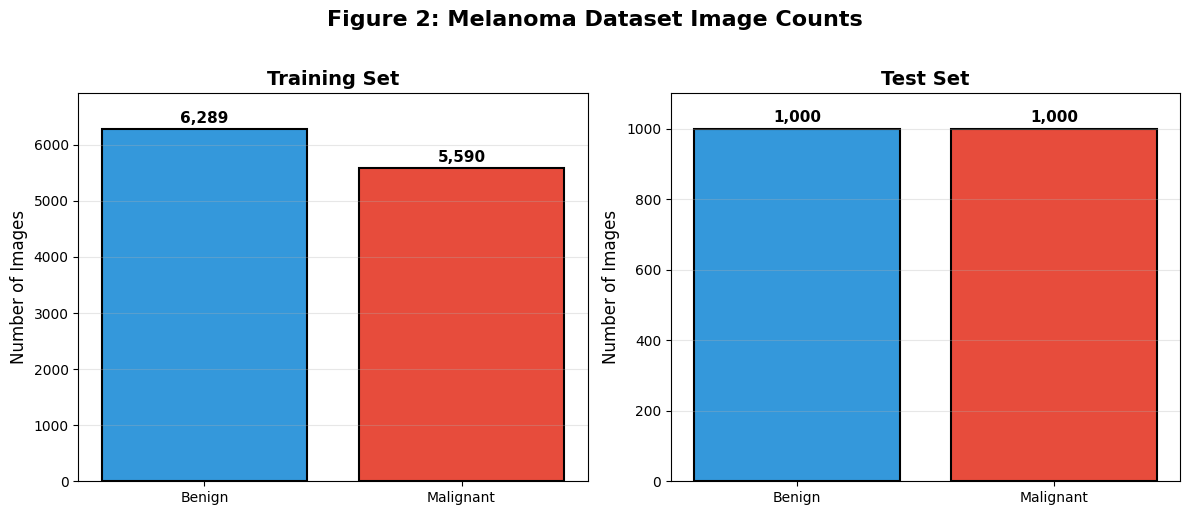

✓ Figure 2 saved



In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['#3498db', '#e74c3c']

# Training set
axes[0].bar(train_counts.keys(), train_counts.values(), color=colors, 
           edgecolor='black', linewidth=1.5)
axes[0].set_title('Training Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_ylim(0, max(train_counts.values()) * 1.1)
axes[0].grid(axis='y', alpha=0.3)
for i, (cls, cnt) in enumerate(train_counts.items()):
    axes[0].text(i, cnt + 100, f'{cnt:,}', ha='center', fontsize=11, fontweight='bold')

# Test set
axes[1].bar(test_counts.keys(), test_counts.values(), color=colors,
           edgecolor='black', linewidth=1.5)
axes[1].set_title('Test Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].set_ylim(0, max(test_counts.values()) * 1.1)
axes[1].grid(axis='y', alpha=0.3)
for i, (cls, cnt) in enumerate(test_counts.items()):
    axes[1].text(i, cnt + 20, f'{cnt:,}', ha='center', fontsize=11, fontweight='bold')

plt.suptitle('Figure 2: Melanoma Dataset Image Counts', 
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(Config.FIGURES_DIR / 'figure_2_dataset_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved\n")

# ### 2.3 Sample Images Visualization

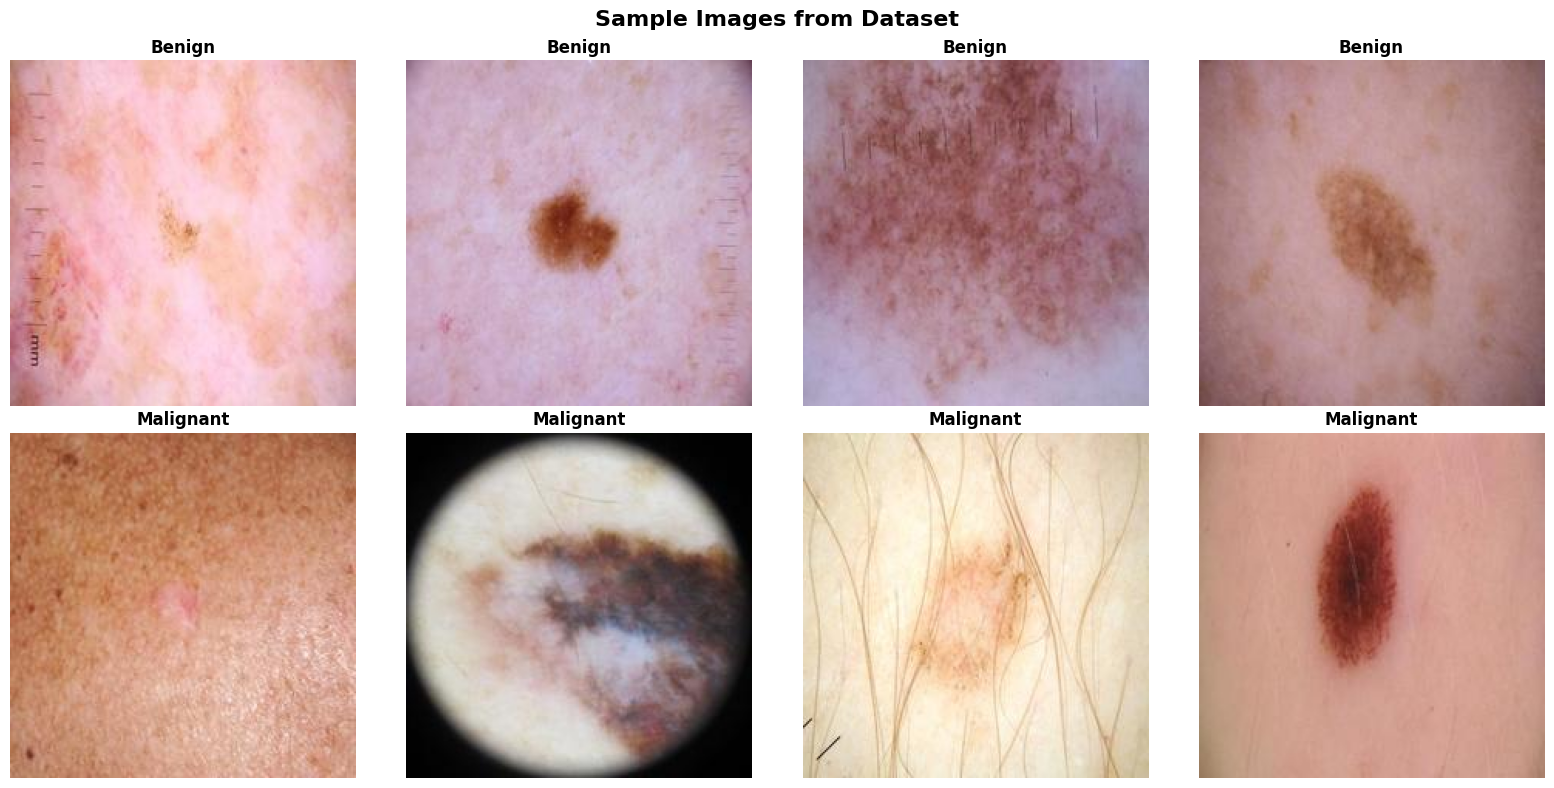

✓ Sample images visualized



In [7]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, class_name in enumerate(Config.CLASSES):
    class_path = Config.TRAIN_DIR / class_name
    samples = list(class_path.glob('*.jpg'))[:4]
    
    for j, img_path in enumerate(samples):
        img = plt.imread(str(img_path))
        axes[idx, j].imshow(img)
        axes[idx, j].set_title(f'{class_name}', fontsize=12, fontweight='bold')
        axes[idx, j].axis('off')

plt.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(Config.FIGURES_DIR / 'sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Sample images visualized\n")

### SECTION 3: DATA PREPARATION

#### 3.1 Data Generators with Mixup

In [8]:
from tensorflow.keras.utils import Sequence

class MixupGenerator(Sequence):
    """Wrapper class for Mixup data augmentation"""
    
    def __init__(self, generator, alpha=0.2):
        self.generator = generator
        self.alpha = alpha
        
    def __len__(self):
        return len(self.generator)
    
    def __getitem__(self, index):
        batch_x, batch_y = self.generator[index]
        batch_size = len(batch_x)
        
        # Generate lambda from beta distribution
        lam = np.random.beta(self.alpha, self.alpha, batch_size)
        
        # Reshape for broadcasting
        lam_x = lam.reshape(batch_size, 1, 1, 1)
        lam_y = lam.reshape(batch_size, 1)
        
        # Random permutation
        indices = np.random.permutation(batch_size)
        
        # Mixup images
        mixed_x = lam_x * batch_x + (1 - lam_x) * batch_x[indices]
        
        # Mixup labels
        y1 = batch_y.reshape(-1, 1) if len(batch_y.shape) == 1 else batch_y
        y2 = batch_y[indices].reshape(-1, 1) if len(batch_y.shape) == 1 else batch_y[indices]
        mixed_y = lam_y * y1 + (1 - lam_y) * y2
        
        return mixed_x, mixed_y.flatten()
    
    def on_epoch_end(self):
        """Shuffle data at end of epoch"""
        if hasattr(self.generator, 'on_epoch_end'):
            self.generator.on_epoch_end()


def create_generators(img_size=224, use_mixup=False):
    """Create training and test generators"""
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=Config.ROTATION_RANGE,
        width_shift_range=Config.WIDTH_SHIFT,
        height_shift_range=Config.HEIGHT_SHIFT,
        shear_range=Config.SHEAR_RANGE,
        zoom_range=Config.ZOOM_RANGE,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=Config.BRIGHTNESS_RANGE,
        fill_mode='reflect'
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        Config.TRAIN_DIR,
        target_size=(img_size, img_size),
        batch_size=Config.BATCH_SIZE,
        class_mode=Config.CLASS_MODE,
        shuffle=True,
        seed=SEED
    )
    
    test_gen = test_datagen.flow_from_directory(
        Config.TEST_DIR,
        target_size=(img_size, img_size),
        batch_size=Config.BATCH_SIZE,
        class_mode=Config.CLASS_MODE,
        shuffle=False
    )
    
    # Apply Mixup wrapper if enabled
    if use_mixup and Config.USE_MIXUP:
        train_gen = MixupGenerator(train_gen, Config.MIXUP_ALPHA)
    
    return train_gen, test_gen

print("✓ Data generators ready (with Mixup support)\n")

✓ Data generators ready (with Mixup support)



### SECTION 4: MODEL ARCHITECTURES

#### 4.1 Vision Transformer (ViT)

In [9]:
@tf.keras.utils.register_keras_serializable(package='Custom')
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

@tf.keras.utils.register_keras_serializable(package='Custom')
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim,
        })
        return config

def build_vit_model():
    """Build Vision Transformer"""
    cfg = Config.MODEL_CONFIG['ViT']
    img_size = cfg['img_size']
    patch_size = cfg['patch_size']
    projection_dim = cfg['projection_dim']
    num_heads = cfg['num_heads']
    transformer_layers = cfg['transformer_layers']
    mlp_head_units = cfg['mlp_head_units']
    
    num_patches = (img_size // patch_size) ** 2
    
    inputs = layers.Input(shape=(img_size, img_size, 3))
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(projection_dim * 2, activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(0.1)(x3)
        x3 = layers.Dense(projection_dim)(x3)
        x3 = layers.Dropout(0.1)(x3)
        encoded_patches = layers.Add()([x3, x2])
    
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    features = representation
    for units in mlp_head_units:
        features = layers.Dense(units, activation=tf.nn.gelu)(features)
        features = layers.Dropout(0.5)(features)
    
    # Feature layer for CBIR
    features = layers.Dense(256, activation='relu', name='feature_layer')(features)
    
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(features)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='ViT')
    
    if Config.USE_LABEL_SMOOTHING:
        loss = keras.losses.BinaryCrossentropy(label_smoothing=Config.LABEL_SMOOTHING)
    else:
        loss = 'binary_crossentropy'
    
    model.compile(
        optimizer=keras.optimizers.Adam(Config.LEARNING_RATE),
        loss=loss,
        metrics=['accuracy', keras.metrics.AUC(name='auc'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )
    
    return model

print("✓ Vision Transformer defined\n")

✓ Vision Transformer defined



#### 4.2 CNN Models (DenseNet, InceptionV3, Xception)

In [10]:
def build_cnn_model(model_name):
    """Build CNN models with improvements"""
    
    config = Config.MODEL_CONFIG[model_name]
    img_size = config['img_size']
    freeze_layers = config['freeze_layers']
    
    input_shape = (img_size, img_size, Config.CHANNELS)
    
    print(f"\nBuilding {model_name}...")
    print(f"  Image size: {img_size}x{img_size}")
    print(f"  Freeze layers: {freeze_layers}")
    
    # Base model
    if model_name == 'DenseNet121':
        base = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'Xception':
        base = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    
    for layer in base.layers[:freeze_layers]:
        layer.trainable = False
    
    inputs = keras.Input(shape=input_shape)
    x = base(inputs, training=False)
    
    # PERBAIKAN: Kurangi jumlah MaxPooling dan cek dimensi
    # Output dari base model biasanya sudah kecil (7x7 atau 8x8)
    if model_name == 'InceptionV3':
        # InceptionV3 output: 8x8xN
        x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        if config.get('use_batchnorm', False):
            x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)  # 4x4
        
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2))(x)  # 2x2
        
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        # HAPUS MaxPooling terakhir - langsung ke GAP
        
        if config.get('use_batchnorm', False):
            x = layers.BatchNormalization()(x)
            print(f"  ✓ BatchNormalization added")
    else:
        # DenseNet121/Xception output: 7x7xN
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2))(x)  # 3x3
        
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        # HAPUS MaxPooling terakhir - langsung ke GAP
    
    # Global Average Pooling - output sudah 1D
    x = layers.GlobalAveragePooling2D()(x)
    # HAPUS Flatten() - sudah tidak perlu!
    
    x = layers.Dense(512, activation='relu', 
                    kernel_regularizer=regularizers.l2(Config.L2_REG))(x)
    x = layers.Dropout(Config.DROPOUT_RATE)(x)
    
    # Feature layer for CBIR
    x = layers.Dense(256, activation='relu', 
                    kernel_regularizer=regularizers.l2(Config.L2_REG),
                    name='feature_layer')(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    
    optimizer_name = config['optimizer']
    if optimizer_name == 'adamax':
        optimizer = keras.optimizers.Adamax(Config.LEARNING_RATE)
    else:
        optimizer = keras.optimizers.Adam(Config.LEARNING_RATE)
    
    if Config.USE_LABEL_SMOOTHING:
        loss = keras.losses.BinaryCrossentropy(label_smoothing=Config.LABEL_SMOOTHING)
        print(f"  ✓ Label smoothing: {Config.LABEL_SMOOTHING}")
    else:
        loss = 'binary_crossentropy'
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', keras.metrics.AUC(name='auc'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )
    
    print(f"  Total params: {model.count_params():,}")
    
    return model

print("✓ CNN model builder ready\n")

✓ CNN model builder ready



#### 4.3 Training Pipeline

In [11]:
def get_callbacks(model_name):
    """Get training callbacks"""
    return [
        keras.callbacks.ModelCheckpoint(
            str(Config.MODEL_DIR / f'{model_name}_best.h5'),
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=Config.PATIENCE,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=5,
            mode='max',
            min_lr=1e-7,
            verbose=1
        ),
        keras.callbacks.CSVLogger(
            str(Config.RESULTS_DIR / f'{model_name}_training.csv')
        )
    ]

def train_model(model, train_gen, test_gen, model_name, use_mixup=False):
    """Train a model"""
    
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_name}")
    if use_mixup:
        print(f"Using Mixup (α={Config.MIXUP_ALPHA})")
    print(f"{'='*80}\n")
    
    callbacks_list = get_callbacks(model_name)
    
    if hasattr(train_gen, 'samples'):
        steps_train = train_gen.samples // Config.BATCH_SIZE
    elif hasattr(train_gen, 'n'):
        steps_train = train_gen.n // Config.BATCH_SIZE
    else:
        # Fallback for wrapped generators
        steps_train = len(list(Config.TRAIN_DIR.rglob('*.jpg'))) // Config.BATCH_SIZE
    
    if hasattr(test_gen, 'samples'):
        steps_val = test_gen.samples // Config.BATCH_SIZE
        test_data = test_gen
    else:
        _, test_data = create_generators(
            Config.MODEL_CONFIG[model_name]['img_size'] if model_name != 'ViT' 
            else Config.MODEL_CONFIG['ViT']['img_size'],
            use_mixup=False
        )
        steps_val = test_data.samples // Config.BATCH_SIZE
    
    start = datetime.now()
    
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_train,
        epochs=Config.EPOCHS,
        validation_data=test_data,
        validation_steps=steps_val,
        callbacks=callbacks_list,
        verbose=1
    )
    
    elapsed = datetime.now() - start
    
    print(f"\n{'='*80}")
    print(f"TRAINING COMPLETE: {model_name}")
    print(f"{'='*80}")
    print(f"  Duration: {elapsed}")
    print(f"  Best val_auc: {max(history.history['val_auc']):.4f}")
    print(f"  Best val_accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"{'='*80}\n")
    
    with open(Config.RESULTS_DIR / f'{model_name}_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
    
    return history, elapsed

print("✓ Training pipeline ready\n")

✓ Training pipeline ready



### SECTION 5: TRAINING ALL MODELS

#### 5.1 Train All 4 Models

In [12]:
print("\n" + "#"*80)
print("# TRAINING PHASE - 4 MODELS")
print("#"*80 + "\n")

training_results = {}
training_times = {}

for idx, model_name in enumerate(Config.MODELS_TO_TRAIN, 1):
    print(f"\n{'#'*80}")
    print(f"# MODEL {idx}/4: {model_name}")
    print(f"{'#'*80}\n")
    
    if model_name == 'ViT':
        model = build_vit_model()
        img_size = Config.MODEL_CONFIG['ViT']['img_size']
    else:
        model = build_cnn_model(model_name)
        img_size = Config.MODEL_CONFIG[model_name]['img_size']
    
    train_gen, test_gen = create_generators(img_size, use_mixup=Config.USE_MIXUP)
    
    history, elapsed = train_model(model, train_gen, test_gen, model_name, use_mixup=Config.USE_MIXUP)
    
    training_results[model_name] = history.history
    training_times[model_name] = elapsed
    
    del model, train_gen, test_gen
    keras.backend.clear_session()

# Summary
print("\n" + "="*80)
print("ALL MODELS TRAINED SUCCESSFULLY")
print("="*80)
for name, time in training_times.items():
    print(f"  {name:20s}: {time}")

total_time = timedelta(seconds=0)
for time in training_times.values():
    total_time += time
print(f"\n  Total training time: {total_time}")
print("="*80 + "\n")


################################################################################
# TRAINING PHASE - 4 MODELS
################################################################################


################################################################################
# MODEL 1/4: DenseNet121
################################################################################


Building DenseNet121...
  Image size: 224x224
  Freeze layers: 121


I0000 00:00:1768779912.723167     100 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
  ✓ Label smoothing: 0.1
  Total params: 9,889,729
Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

TRAINING: DenseNet121
Using Mixup (α=0.2)

Epoch 1/40


I0000 00:00:1768779960.561813     167 service.cc:152] XLA service 0x7924f40066a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768779960.561849     167 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768779960.612610     167 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768779960.817379     167 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4197 - auc: 0.7636 - loss: 0.5874 - precision: 0.8897 - recall: 0.5954
Epoch 1: val_auc improved from -inf to 0.97324, saving model to /kaggle/working/models/DenseNet121_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.4197 - auc: 0.7637 - loss: 0.5872 - precision: 0.8898 - recall: 0.5955 - val_accuracy: 0.9269 - val_auc: 0.9732 - val_loss: 0.3767 - val_precision: 0.9208 - val_recall: 0.9329 - learning_rate: 0.0010
Epoch 2/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 47s 127ms/step - accuracy: 0.4375 - auc: 0.9130 - loss: 0.4983 - precision: 1.0000 - recall: 0.6087
Epoch 2: val_auc did not improve from 0.97324
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4375 - auc: 0.9130 - loss: 0.4983 - precision: 1.0000 - recall: 0.6087 - val_accuracy: 0.9264 - val_auc: 0.9717 - val_loss: 0.3800 - val_precision: 0.9249 - val_recall: 0.9268 - learning_rate: 0.0010
Epoch 3/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.4790 - auc: 0.8322 - loss: 0.4769 - precision: 0.9452 - recall: 0.6358
Epoch 3: val_auc improved from 0.97324 to 0.97754, saving model to /kaggle/working/models/DenseNet121_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 178s 478ms/step - accuracy: 0.4790 - auc: 0.8321 - loss: 0.4769 - precision: 0.9452 - recall: 0.6358 - val_accuracy: 0.9138 - val_auc: 0.9775 - val_loss: 0.3819 - val_precision: 0.9404 - val_recall: 0.8821 - learning_rate: 0.0010
Epoch 4/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.4688 - auc: 0.8430 - loss: 0.4022 - precision: 0.9412 - recall: 0.6957
Epoch 4: val_auc improved from 0.97754 to 0.97811, saving model to /kaggle/working/models/DenseNet121_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4688 - auc: 0.8430 - loss: 0.4022 - precision: 0.9412 - recall: 0.6957 - val_accuracy: 0.9123 - val_auc: 0.9781 - val_loss: 0.3818 - val_precision: 0.9421 - val_recall: 0.8770 - learning_rate: 0.0010
Epoch 5/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.4662 - auc: 0.8200 - loss: 0.4649 - precision: 0.9447 - recall: 0.6240
Epoch 5: val_auc improved from 0.97811 to 0.97872, saving model to /kaggle/working/models/DenseNet121_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 176s 474ms/step - accuracy: 0.4662 - auc: 0.8200 - loss: 0.4649 - precision: 0.9447 - recall: 0.6239 - val_accuracy: 0.9355 - val_auc: 0.9787 - val_loss: 0.3638 - val_precision: 0.9297 - val_recall: 0.9411 - learning_rate: 0.0010
Epoch 6/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.5312 - auc: 0.9333 - loss: 0.4414 - precision: 1.0000 - recall: 0.8000
Epoch 6: val_auc did not improve from 0.97872
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5312 - auc: 0.9333 - loss: 0.4414 - precision: 1.0000 - recall: 0.8000 - val_accuracy: 0.9355 - val_auc: 0.9784 - val_loss: 0.3643 - val_precision: 0.9323 - val_recall: 0.9380 - learning_rate: 0.0010
Epoch 7/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.4733 - auc: 0.8257 - loss: 0.4524 - precision: 0.9529 - recall: 0.6270
Epoch 7: val_auc did not improve from 0.97872
371/371 ━━━━━━━━━━━━━━━━━━━━ 175s 471ms/step - accuracy: 0.4733 - auc: 0.8257 - loss: 0.4524 - precision: 0.9529 - 

371/371 ━━━━━━━━━━━━━━━━━━━━ 177s 478ms/step - accuracy: 0.4760 - auc: 0.8308 - loss: 0.4349 - precision: 0.9547 - recall: 0.6294 - val_accuracy: 0.9350 - val_auc: 0.9824 - val_loss: 0.3577 - val_precision: 0.9572 - val_recall: 0.9096 - learning_rate: 5.0000e-04
Epoch 12/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.6250 - auc: 0.9792 - loss: 0.4179 - precision: 1.0000 - recall: 0.9167
Epoch 12: val_auc did not improve from 0.98239
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6250 - auc: 0.9792 - loss: 0.4179 - precision: 1.0000 - recall: 0.9167 - val_accuracy: 0.9355 - val_auc: 0.9823 - val_loss: 0.3574 - val_precision: 0.9582 - val_recall: 0.9096 - learning_rate: 5.0000e-04
Epoch 13/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.4790 - auc: 0.8374 - loss: 0.4193 - precision: 0.9634 - recall: 0.6242
Epoch 13: val_auc did not improve from 0.98239
371/371 ━━━━━━━━━━━━━━━━━━━━ 174s 470ms/step - accuracy: 0.4789 - auc: 0.8374 - loss: 0.4193 - precisio

371/371 ━━━━━━━━━━━━━━━━━━━━ 175s 472ms/step - accuracy: 0.4883 - auc: 0.8402 - loss: 0.4031 - precision: 0.9717 - recall: 0.6296 - val_accuracy: 0.9405 - val_auc: 0.9826 - val_loss: 0.3294 - val_precision: 0.9492 - val_recall: 0.9299 - learning_rate: 2.5000e-04
Epoch 18/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.5625 - auc: 0.7969 - loss: 0.3742 - precision: 1.0000 - recall: 0.5417
Epoch 18: val_auc improved from 0.98257 to 0.98261, saving model to /kaggle/working/models/DenseNet121_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5625 - auc: 0.7969 - loss: 0.3742 - precision: 1.0000 - recall: 0.5417 - val_accuracy: 0.9405 - val_auc: 0.9826 - val_loss: 0.3290 - val_precision: 0.9492 - val_recall: 0.9299 - learning_rate: 2.5000e-04
Epoch 19/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.4872 - auc: 0.8538 - loss: 0.3974 - precision: 0.9772 - recall: 0.6403
Epoch 19: val_auc improved from 0.98261 to 0.98415, saving model to /kaggle/working/models/DenseNet121_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 170s 458ms/step - accuracy: 0.4872 - auc: 0.8538 - loss: 0.3974 - precision: 0.9772 - recall: 0.6403 - val_accuracy: 0.9451 - val_auc: 0.9841 - val_loss: 0.3245 - val_precision: 0.9406 - val_recall: 0.9492 - learning_rate: 2.5000e-04
Epoch 20/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.3125 - auc: 0.6812 - loss: 0.4752 - precision: 0.8571 - recall: 0.5217
Epoch 20: val_auc did not improve from 0.98415
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3125 - auc: 0.6812 - loss: 0.4752 - precision: 0.8571 - recall: 0.5217 - val_accuracy: 0.9451 - val_auc: 0.9839 - val_loss: 0.3251 - val_precision: 0.9406 - val_recall: 0.9492 - learning_rate: 2.5000e-04
Epoch 21/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.4906 - auc: 0.8468 - loss: 0.3913 - precision: 0.9743 - recall: 0.6415
Epoch 21: val_auc did not improve from 0.98415
371/371 ━━━━━━━━━━━━━━━━━━━━ 172s 465ms/step - accuracy: 0.4906 - auc: 0.8468 - loss: 0.3913 - precisio

371/371 ━━━━━━━━━━━━━━━━━━━━ 176s 475ms/step - accuracy: 0.4897 - auc: 0.8475 - loss: 0.3791 - precision: 0.9787 - recall: 0.6494 - val_accuracy: 0.9415 - val_auc: 0.9856 - val_loss: 0.3155 - val_precision: 0.9465 - val_recall: 0.9350 - learning_rate: 1.2500e-04
Epoch 28/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.3750 - auc: 0.8099 - loss: 0.4006 - precision: 1.0000 - recall: 0.5000
Epoch 28: val_auc improved from 0.98556 to 0.98560, saving model to /kaggle/working/models/DenseNet121_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3750 - auc: 0.8099 - loss: 0.4006 - precision: 1.0000 - recall: 0.5000 - val_accuracy: 0.9415 - val_auc: 0.9856 - val_loss: 0.3156 - val_precision: 0.9474 - val_recall: 0.9339 - learning_rate: 1.2500e-04
Epoch 29/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.4941 - auc: 0.8494 - loss: 0.3735 - precision: 0.9794 - recall: 0.6477
Epoch 29: val_auc did not improve from 0.98560
371/371 ━━━━━━━━━━━━━━━━━━━━ 175s 470ms/step - accuracy: 0.4941 - auc: 0.8494 - loss: 0.3735 - precision: 0.9794 - recall: 0.6477 - val_accuracy: 0.9309 - val_auc: 0.9820 - val_loss: 0.3295 - val_precision: 0.9380 - val_recall: 0.9217 - learning_rate: 1.2500e-04
Epoch 30/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.6875 - auc: 0.9955 - loss: 0.3203 - precision: 1.0000 - recall: 0.8182
Epoch 30: val_auc did not improve from 0.98560
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6875 - auc: 0.9955 - loss: 0.3203 - precision: 

371/371 ━━━━━━━━━━━━━━━━━━━━ 173s 465ms/step - accuracy: 0.4945 - auc: 0.8448 - loss: 0.3692 - precision: 0.9856 - recall: 0.6355 - val_accuracy: 0.9420 - val_auc: 0.9859 - val_loss: 0.3129 - val_precision: 0.9420 - val_recall: 0.9411 - learning_rate: 6.2500e-05
Epoch 36/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.3750 - auc: 0.8073 - loss: 0.3980 - precision: 1.0000 - recall: 0.4583
Epoch 36: val_auc did not improve from 0.98589
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3750 - auc: 0.8073 - loss: 0.3980 - precision: 1.0000 - recall: 0.4583 - val_accuracy: 0.9420 - val_auc: 0.9858 - val_loss: 0.3130 - val_precision: 0.9420 - val_recall: 0.9411 - learning_rate: 6.2500e-05
Epoch 37/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.4941 - auc: 0.8414 - loss: 0.3610 - precision: 0.9808 - recall: 0.6339
Epoch 37: val_auc did not improve from 0.98589
371/371 ━━━━━━━━━━━━━━━━━━━━ 176s 476ms/step - accuracy: 0.4941 - auc: 0.8414 - loss: 0.3610 - precisi

371/371 ━━━━━━━━━━━━━━━━━━━━ 367s 850ms/step - accuracy: 0.4103 - auc: 0.7670 - loss: 0.5786 - precision: 0.9002 - recall: 0.5885 - val_accuracy: 0.8654 - val_auc: 0.9388 - val_loss: 0.4645 - val_precision: 0.8256 - val_recall: 0.9238 - learning_rate: 0.0010
Epoch 2/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:00 165ms/step - accuracy: 0.3750 - auc: 0.6700 - loss: 0.5952 - precision: 0.7500 - recall: 0.6316
Epoch 2: val_auc did not improve from 0.93885
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3750 - auc: 0.6700 - loss: 0.5952 - precision: 0.7500 - recall: 0.6316 - val_accuracy: 0.8604 - val_auc: 0.9363 - val_loss: 0.4675 - val_precision: 0.8188 - val_recall: 0.9228 - learning_rate: 0.0010
Epoch 3/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.4456 - auc: 0.8017 - loss: 0.5050 - precision: 0.9314 - recall: 0.5983
Epoch 3: val_auc improved from 0.93885 to 0.97104, saving model to /kaggle/working/models/InceptionV3_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 286s 772ms/step - accuracy: 0.4456 - auc: 0.8017 - loss: 0.5049 - precision: 0.9314 - recall: 0.5983 - val_accuracy: 0.9078 - val_auc: 0.9710 - val_loss: 0.3946 - val_precision: 0.9435 - val_recall: 0.8659 - learning_rate: 0.0010
Epoch 4/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 58s 159ms/step - accuracy: 0.5938 - auc: 0.8290 - loss: 0.3981 - precision: 1.0000 - recall: 0.6667
Epoch 4: val_auc did not improve from 0.97104
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5938 - auc: 0.8290 - loss: 0.3981 - precision: 1.0000 - recall: 0.6667 - val_accuracy: 0.9073 - val_auc: 0.9707 - val_loss: 0.3968 - val_precision: 0.9454 - val_recall: 0.8628 - learning_rate: 0.0010
Epoch 5/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.4636 - auc: 0.8162 - loss: 0.4744 - precision: 0.9459 - recall: 0.6058
Epoch 5: val_auc improved from 0.97104 to 0.97531, saving model to /kaggle/working/models/InceptionV3_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 288s 777ms/step - accuracy: 0.4636 - auc: 0.8162 - loss: 0.4744 - precision: 0.9459 - recall: 0.6058 - val_accuracy: 0.9254 - val_auc: 0.9753 - val_loss: 0.3633 - val_precision: 0.9172 - val_recall: 0.9339 - learning_rate: 0.0010
Epoch 6/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 58s 159ms/step - accuracy: 0.4688 - auc: 0.7436 - loss: 0.5000 - precision: 0.9375 - recall: 0.5769
Epoch 6: val_auc improved from 0.97531 to 0.97559, saving model to /kaggle/working/models/InceptionV3_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4688 - auc: 0.7436 - loss: 0.5000 - precision: 0.9375 - recall: 0.5769 - val_accuracy: 0.9279 - val_auc: 0.9756 - val_loss: 0.3610 - val_precision: 0.9192 - val_recall: 0.9370 - learning_rate: 0.0010
Epoch 7/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.4702 - auc: 0.8159 - loss: 0.4601 - precision: 0.9389 - recall: 0.6130
Epoch 7: val_auc did not improve from 0.97559
371/371 ━━━━━━━━━━━━━━━━━━━━ 287s 772ms/step - accuracy: 0.4702 - auc: 0.8159 - loss: 0.4601 - precision: 0.9389 - recall: 0.6130 - val_accuracy: 0.8730 - val_auc: 0.9739 - val_loss: 0.4187 - val_precision: 0.9610 - val_recall: 0.7754 - learning_rate: 0.0010
Epoch 8/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 58s 159ms/step - accuracy: 0.2812 - auc: 0.9359 - loss: 0.5358 - precision: 1.0000 - recall: 0.4615
Epoch 8: val_auc did not improve from 0.97559
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2812 - auc: 0.9359 - loss: 0.5358 - precision: 1.0000 - re

371/371 ━━━━━━━━━━━━━━━━━━━━ 294s 792ms/step - accuracy: 0.4752 - auc: 0.8286 - loss: 0.4326 - precision: 0.9532 - recall: 0.6293 - val_accuracy: 0.9224 - val_auc: 0.9780 - val_loss: 0.3372 - val_precision: 0.9014 - val_recall: 0.9472 - learning_rate: 0.0010
Epoch 12/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 58s 158ms/step - accuracy: 0.4688 - auc: 0.8354 - loss: 0.3945 - precision: 1.0000 - recall: 0.5500
Epoch 12: val_auc improved from 0.97795 to 0.97830, saving model to /kaggle/working/models/InceptionV3_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4688 - auc: 0.8354 - loss: 0.3945 - precision: 1.0000 - recall: 0.5500 - val_accuracy: 0.9224 - val_auc: 0.9783 - val_loss: 0.3371 - val_precision: 0.8983 - val_recall: 0.9512 - learning_rate: 0.0010
Epoch 13/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.4636 - auc: 0.8199 - loss: 0.4322 - precision: 0.9463 - recall: 0.6287
Epoch 13: val_auc did not improve from 0.97830
371/371 ━━━━━━━━━━━━━━━━━━━━ 294s 791ms/step - accuracy: 0.4636 - auc: 0.8199 - loss: 0.4321 - precision: 0.9463 - recall: 0.6287 - val_accuracy: 0.8906 - val_auc: 0.9572 - val_loss: 0.3818 - val_precision: 0.8786 - val_recall: 0.9045 - learning_rate: 0.0010
Epoch 14/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 58s 158ms/step - accuracy: 0.6875 - auc: 0.8647 - loss: 0.3343 - precision: 0.8667 - recall: 0.7647
Epoch 14: val_auc did not improve from 0.97830
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6875 - auc: 0.8647 - loss: 0.3343 - precision: 0.8667 

2026-01-19 01:48:58.717435: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-19 01:48:58.912098: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-19 01:49:00.368167: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-19 01:49:00.568148: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-19 01:49:01.014190: E external/local_xla/xla/stream_

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.3622 - auc: 0.6680 - loss: 0.6712 - precision: 0.8484 - recall: 0.3879
Epoch 1: val_auc improved from -inf to 0.94574, saving model to /kaggle/working/models/Xception_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 387s 915ms/step - accuracy: 0.3623 - auc: 0.6682 - loss: 0.6710 - precision: 0.8485 - recall: 0.3883 - val_accuracy: 0.8639 - val_auc: 0.9457 - val_loss: 0.4565 - val_precision: 0.9301 - val_recall: 0.7846 - learning_rate: 0.0010
Epoch 2/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:27 237ms/step - accuracy: 0.4688 - auc: 0.8744 - loss: 0.5790 - precision: 1.0000 - recall: 0.6522
Epoch 2: val_auc did not improve from 0.94574
371/371 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.4688 - auc: 0.8744 - loss: 0.5790 - precision: 1.0000 - recall: 0.6522 - val_accuracy: 0.8659 - val_auc: 0.9437 - val_loss: 0.4462 - val_precision: 0.9305 - val_recall: 0.7886 - learning_rate: 0.0010
Epoch 3/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.4556 - auc: 0.8021 - loss: 0.4950 - precision: 0.9299 - recall: 0.6067
Epoch 3: val_auc improved from 0.94574 to 0.96928, saving model to /kaggle/working/models/Xception_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 307s 828ms/step - accuracy: 0.4556 - auc: 0.8021 - loss: 0.4949 - precision: 0.9299 - recall: 0.6067 - val_accuracy: 0.8059 - val_auc: 0.9693 - val_loss: 0.4736 - val_precision: 0.9792 - val_recall: 0.6220 - learning_rate: 0.0010
Epoch 4/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:26 233ms/step - accuracy: 0.4375 - auc: 0.8009 - loss: 0.5075 - precision: 0.7647 - recall: 0.6190
Epoch 4: val_auc did not improve from 0.96928
371/371 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.4375 - auc: 0.8009 - loss: 0.5075 - precision: 0.7647 - recall: 0.6190 - val_accuracy: 0.8049 - val_auc: 0.9690 - val_loss: 0.4746 - val_precision: 0.9791 - val_recall: 0.6199 - learning_rate: 0.0010
Epoch 5/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.4551 - auc: 0.8176 - loss: 0.4719 - precision: 0.9369 - recall: 0.6032
Epoch 5: val_auc improved from 0.96928 to 0.97221, saving model to /kaggle/working/models/Xception_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 320s 861ms/step - accuracy: 0.4551 - auc: 0.8176 - loss: 0.4719 - precision: 0.9369 - recall: 0.6032 - val_accuracy: 0.7697 - val_auc: 0.9722 - val_loss: 0.5364 - val_precision: 0.9871 - val_recall: 0.5427 - learning_rate: 0.0010
Epoch 6/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:26 234ms/step - accuracy: 0.5312 - auc: 0.8036 - loss: 0.3683 - precision: 0.9286 - recall: 0.6842
Epoch 6: val_auc did not improve from 0.97221
371/371 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5312 - auc: 0.8036 - loss: 0.3683 - precision: 0.9286 - recall: 0.6842 - val_accuracy: 0.7621 - val_auc: 0.9714 - val_loss: 0.5582 - val_precision: 0.9867 - val_recall: 0.5274 - learning_rate: 0.0010
Epoch 7/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.4742 - auc: 0.8167 - loss: 0.4429 - precision: 0.9458 - recall: 0.6143
Epoch 7: val_auc improved from 0.97221 to 0.97886, saving model to /kaggle/working/models/Xception_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 309s 833ms/step - accuracy: 0.4742 - auc: 0.8167 - loss: 0.4429 - precision: 0.9458 - recall: 0.6144 - val_accuracy: 0.8750 - val_auc: 0.9789 - val_loss: 0.4039 - val_precision: 0.9718 - val_recall: 0.7703 - learning_rate: 0.0010
Epoch 8/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:26 233ms/step - accuracy: 0.5938 - auc: 0.9295 - loss: 0.4156 - precision: 1.0000 - recall: 0.6818
Epoch 8: val_auc did not improve from 0.97886
371/371 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5938 - auc: 0.9295 - loss: 0.4156 - precision: 1.0000 - recall: 0.6818 - val_accuracy: 0.8705 - val_auc: 0.9787 - val_loss: 0.4097 - val_precision: 0.9715 - val_recall: 0.7612 - learning_rate: 0.0010
Epoch 9/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.4597 - auc: 0.8220 - loss: 0.4462 - precision: 0.9482 - recall: 0.6022
Epoch 9: val_auc did not improve from 0.97886
371/371 ━━━━━━━━━━━━━━━━━━━━ 312s 841ms/step - accuracy: 0.4597 - auc: 0.8220 - loss: 0.4462 - precision: 0.9482 

371/371 ━━━━━━━━━━━━━━━━━━━━ 317s 853ms/step - accuracy: 0.4694 - auc: 0.8340 - loss: 0.4166 - precision: 0.9579 - recall: 0.6190 - val_accuracy: 0.9320 - val_auc: 0.9792 - val_loss: 0.3275 - val_precision: 0.9390 - val_recall: 0.9228 - learning_rate: 5.0000e-04
Epoch 14/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:26 234ms/step - accuracy: 0.5625 - auc: 0.9049 - loss: 0.3632 - precision: 1.0000 - recall: 0.6842
Epoch 14: val_auc improved from 0.97922 to 0.97951, saving model to /kaggle/working/models/Xception_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5625 - auc: 0.9049 - loss: 0.3632 - precision: 1.0000 - recall: 0.6842 - val_accuracy: 0.9315 - val_auc: 0.9795 - val_loss: 0.3263 - val_precision: 0.9389 - val_recall: 0.9217 - learning_rate: 5.0000e-04
Epoch 15/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.4726 - auc: 0.8418 - loss: 0.4131 - precision: 0.9599 - recall: 0.6396
Epoch 15: val_auc improved from 0.97951 to 0.98200, saving model to /kaggle/working/models/Xception_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 311s 837ms/step - accuracy: 0.4726 - auc: 0.8418 - loss: 0.4131 - precision: 0.9599 - recall: 0.6395 - val_accuracy: 0.9279 - val_auc: 0.9820 - val_loss: 0.3294 - val_precision: 0.9556 - val_recall: 0.8963 - learning_rate: 5.0000e-04
Epoch 16/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:26 234ms/step - accuracy: 0.3750 - auc: 0.8686 - loss: 0.6033 - precision: 0.9286 - recall: 0.5200
Epoch 16: val_auc did not improve from 0.98200
371/371 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3750 - auc: 0.8686 - loss: 0.6033 - precision: 0.9286 - recall: 0.5200 - val_accuracy: 0.9294 - val_auc: 0.9816 - val_loss: 0.3284 - val_precision: 0.9509 - val_recall: 0.9045 - learning_rate: 5.0000e-04
Epoch 17/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.4851 - auc: 0.8385 - loss: 0.3933 - precision: 0.9632 - recall: 0.6434
Epoch 17: val_auc did not improve from 0.98200
371/371 ━━━━━━━━━━━━━━━━━━━━ 311s 837ms/step - accuracy: 0.4851 - auc: 0.8385 - loss: 0.3933 - precis

371/371 ━━━━━━━━━━━━━━━━━━━━ 308s 830ms/step - accuracy: 0.4945 - auc: 0.8403 - loss: 0.3839 - precision: 0.9743 - recall: 0.6428 - val_accuracy: 0.9113 - val_auc: 0.9821 - val_loss: 0.3379 - val_precision: 0.9550 - val_recall: 0.8618 - learning_rate: 2.5000e-04
Epoch 22/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:26 233ms/step - accuracy: 0.4688 - auc: 0.9227 - loss: 0.3599 - precision: 1.0000 - recall: 0.7391
Epoch 22: val_auc improved from 0.98208 to 0.98211, saving model to /kaggle/working/models/Xception_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4688 - auc: 0.9227 - loss: 0.3599 - precision: 1.0000 - recall: 0.7391 - val_accuracy: 0.9118 - val_auc: 0.9821 - val_loss: 0.3377 - val_precision: 0.9560 - val_recall: 0.8618 - learning_rate: 2.5000e-04
Epoch 23/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.4796 - auc: 0.8388 - loss: 0.3864 - precision: 0.9595 - recall: 0.6368
Epoch 23: val_auc did not improve from 0.98211
371/371 ━━━━━━━━━━━━━━━━━━━━ 318s 857ms/step - accuracy: 0.4796 - auc: 0.8388 - loss: 0.3864 - precision: 0.9595 - recall: 0.6368 - val_accuracy: 0.9229 - val_auc: 0.9796 - val_loss: 0.3259 - val_precision: 0.9397 - val_recall: 0.9024 - learning_rate: 2.5000e-04
Epoch 24/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:26 235ms/step - accuracy: 0.4375 - auc: 0.8182 - loss: 0.3519 - precision: 1.0000 - recall: 0.6364
Epoch 24: val_auc did not improve from 0.98211
371/371 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.4375 - auc: 0.8182 - loss: 0.3519 - precision

371/371 ━━━━━━━━━━━━━━━━━━━━ 311s 838ms/step - accuracy: 0.4872 - auc: 0.8458 - loss: 0.3781 - precision: 0.9781 - recall: 0.6437 - val_accuracy: 0.9194 - val_auc: 0.9828 - val_loss: 0.3305 - val_precision: 0.9578 - val_recall: 0.8760 - learning_rate: 2.5000e-04
Epoch 26/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:26 233ms/step - accuracy: 0.5625 - auc: 0.8720 - loss: 0.2917 - precision: 1.0000 - recall: 0.6957
Epoch 26: val_auc did not improve from 0.98279
371/371 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5625 - auc: 0.8720 - loss: 0.2917 - precision: 1.0000 - recall: 0.6957 - val_accuracy: 0.9199 - val_auc: 0.9826 - val_loss: 0.3319 - val_precision: 0.9588 - val_recall: 0.8760 - learning_rate: 2.5000e-04
Epoch 27/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.4918 - auc: 0.8415 - loss: 0.3749 - precision: 0.9756 - recall: 0.6350
Epoch 27: val_auc did not improve from 0.98279
371/371 ━━━━━━━━━━━━━━━━━━━━ 310s 835ms/step - accuracy: 0.4918 - auc: 0.8415 - loss: 0.3749 - precis

371/371 ━━━━━━━━━━━━━━━━━━━━ 309s 832ms/step - accuracy: 0.4879 - auc: 0.8435 - loss: 0.3654 - precision: 0.9773 - recall: 0.6348 - val_accuracy: 0.9380 - val_auc: 0.9830 - val_loss: 0.3070 - val_precision: 0.9362 - val_recall: 0.9390 - learning_rate: 1.2500e-04
Epoch 32/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:25 232ms/step - accuracy: 0.6562 - auc: 0.9710 - loss: 0.3920 - precision: 1.0000 - recall: 0.8261
Epoch 32: val_auc did not improve from 0.98304
371/371 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6562 - auc: 0.9710 - loss: 0.3920 - precision: 1.0000 - recall: 0.8261 - val_accuracy: 0.9370 - val_auc: 0.9829 - val_loss: 0.3077 - val_precision: 0.9369 - val_recall: 0.9360 - learning_rate: 1.2500e-04
Epoch 33/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.4837 - auc: 0.8355 - loss: 0.3567 - precision: 0.9825 - recall: 0.6313
Epoch 33: val_auc did not improve from 0.98304
371/371 ━━━━━━━━━━━━━━━━━━━━ 296s 798ms/step - accuracy: 0.4837 - auc: 0.8355 - loss: 0.3567 - precis

371/371 ━━━━━━━━━━━━━━━━━━━━ 240s 524ms/step - accuracy: 0.2838 - auc: 0.5287 - loss: 1.4343 - precision: 0.7482 - recall: 0.4783 - val_accuracy: 0.6119 - val_auc: 0.8007 - val_loss: 0.6441 - val_precision: 0.7635 - val_recall: 0.3150 - learning_rate: 0.0010
Epoch 2/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.3750 - auc: 0.7205 - loss: 0.6956 - precision: 1.0000 - recall: 0.2727
Epoch 2: val_auc improved from 0.80070 to 0.80218, saving model to /kaggle/working/models/ViT_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3750 - auc: 0.7205 - loss: 0.6956 - precision: 1.0000 - recall: 0.2727 - val_accuracy: 0.5963 - val_auc: 0.8022 - val_loss: 0.6717 - val_precision: 0.8144 - val_recall: 0.2409 - learning_rate: 0.0010
Epoch 3/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3742 - auc: 0.7120 - loss: 0.5946 - precision: 0.8682 - recall: 0.5107
Epoch 3: val_auc improved from 0.80218 to 0.85295, saving model to /kaggle/working/models/ViT_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 167s 450ms/step - accuracy: 0.3742 - auc: 0.7120 - loss: 0.5946 - precision: 0.8682 - recall: 0.5108 - val_accuracy: 0.7263 - val_auc: 0.8530 - val_loss: 0.5586 - val_precision: 0.7853 - val_recall: 0.6169 - learning_rate: 0.0010
Epoch 4/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.4688 - auc: 0.6891 - loss: 0.5957 - precision: 0.9000 - recall: 0.6923
Epoch 4: val_auc improved from 0.85295 to 0.85367, saving model to /kaggle/working/models/ViT_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4688 - auc: 0.6891 - loss: 0.5957 - precision: 0.9000 - recall: 0.6923 - val_accuracy: 0.7238 - val_auc: 0.8537 - val_loss: 0.5644 - val_precision: 0.7930 - val_recall: 0.5996 - learning_rate: 0.0010
Epoch 5/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.4204 - auc: 0.7542 - loss: 0.5362 - precision: 0.8841 - recall: 0.5764
Epoch 5: val_auc improved from 0.85367 to 0.93715, saving model to /kaggle/working/models/ViT_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 168s 454ms/step - accuracy: 0.4204 - auc: 0.7542 - loss: 0.5362 - precision: 0.8842 - recall: 0.5764 - val_accuracy: 0.8347 - val_auc: 0.9371 - val_loss: 0.4468 - val_precision: 0.9010 - val_recall: 0.7490 - learning_rate: 0.0010
Epoch 6/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.2812 - auc: 0.6198 - loss: 0.4906 - precision: 0.8235 - recall: 0.5833
Epoch 6: val_auc improved from 0.93715 to 0.93752, saving model to /kaggle/working/models/ViT_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2812 - auc: 0.6198 - loss: 0.4906 - precision: 0.8235 - recall: 0.5833 - val_accuracy: 0.8281 - val_auc: 0.9375 - val_loss: 0.4513 - val_precision: 0.9004 - val_recall: 0.7348 - learning_rate: 0.0010
Epoch 7/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.4345 - auc: 0.7789 - loss: 0.5096 - precision: 0.9055 - recall: 0.5936
Epoch 7: val_auc did not improve from 0.93752
371/371 ━━━━━━━━━━━━━━━━━━━━ 168s 453ms/step - accuracy: 0.4345 - auc: 0.7789 - loss: 0.5096 - precision: 0.9055 - recall: 0.5937 - val_accuracy: 0.8286 - val_auc: 0.9265 - val_loss: 0.5174 - val_precision: 0.8824 - val_recall: 0.7551 - learning_rate: 0.0010
Epoch 8/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.7188 - auc: 0.8254 - loss: 0.5308 - precision: 0.9167 - recall: 0.7857
Epoch 8: val_auc did not improve from 0.93752
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7188 - auc: 0.8254 - loss: 0.5308 - precision: 0.9167 - reca

371/371 ━━━━━━━━━━━━━━━━━━━━ 165s 444ms/step - accuracy: 0.4506 - auc: 0.7994 - loss: 0.4850 - precision: 0.9097 - recall: 0.6330 - val_accuracy: 0.8478 - val_auc: 0.9407 - val_loss: 0.4494 - val_precision: 0.8984 - val_recall: 0.7815 - learning_rate: 5.0000e-04
Epoch 14/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.4375 - auc: 0.7705 - loss: 0.5540 - precision: 0.9286 - recall: 0.5909
Epoch 14: val_auc improved from 0.94067 to 0.94113, saving model to /kaggle/working/models/ViT_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4375 - auc: 0.7705 - loss: 0.5540 - precision: 0.9286 - recall: 0.5909 - val_accuracy: 0.8478 - val_auc: 0.9411 - val_loss: 0.4503 - val_precision: 0.9002 - val_recall: 0.7795 - learning_rate: 5.0000e-04
Epoch 15/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4429 - auc: 0.8014 - loss: 0.4731 - precision: 0.9184 - recall: 0.6270
Epoch 15: val_auc improved from 0.94113 to 0.94726, saving model to /kaggle/working/models/ViT_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 166s 448ms/step - accuracy: 0.4429 - auc: 0.8014 - loss: 0.4731 - precision: 0.9184 - recall: 0.6271 - val_accuracy: 0.8478 - val_auc: 0.9473 - val_loss: 0.4483 - val_precision: 0.9159 - val_recall: 0.7632 - learning_rate: 5.0000e-04
Epoch 16/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.4688 - auc: 0.8057 - loss: 0.4451 - precision: 0.8333 - recall: 0.5263
Epoch 16: val_auc did not improve from 0.94726
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4688 - auc: 0.8057 - loss: 0.4451 - precision: 0.8333 - recall: 0.5263 - val_accuracy: 0.8140 - val_auc: 0.9452 - val_loss: 0.4734 - val_precision: 0.9277 - val_recall: 0.6778 - learning_rate: 5.0000e-04
Epoch 17/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4430 - auc: 0.7916 - loss: 0.4893 - precision: 0.9115 - recall: 0.6174
Epoch 17: val_auc improved from 0.94726 to 0.95020, saving model to /kaggle/working/models/ViT_best.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 167s 449ms/step - accuracy: 0.4430 - auc: 0.7916 - loss: 0.4893 - precision: 0.9115 - recall: 0.6174 - val_accuracy: 0.8831 - val_auc: 0.9502 - val_loss: 0.4096 - val_precision: 0.8876 - val_recall: 0.8750 - learning_rate: 5.0000e-04
Epoch 18/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.3125 - auc: 0.7597 - loss: 0.5346 - precision: 0.8235 - recall: 0.6667
Epoch 18: val_auc did not improve from 0.95020
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3125 - auc: 0.7597 - loss: 0.5346 - precision: 0.8235 - recall: 0.6667 - val_accuracy: 0.8785 - val_auc: 0.9501 - val_loss: 0.4124 - val_precision: 0.8940 - val_recall: 0.8567 - learning_rate: 5.0000e-04
Epoch 19/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.4386 - auc: 0.7917 - loss: 0.4798 - precision: 0.9139 - recall: 0.6105
Epoch 19: val_auc did not improve from 0.95020
371/371 ━━━━━━━━━━━━━━━━━━━━ 168s 453ms/step - accuracy: 0.4386 - auc: 0.7917 - loss: 0.4798 - precision

371/371 ━━━━━━━━━━━━━━━━━━━━ 171s 461ms/step - accuracy: 0.4565 - auc: 0.8116 - loss: 0.4673 - precision: 0.9298 - recall: 0.6181 - val_accuracy: 0.8533 - val_auc: 0.9514 - val_loss: 0.4269 - val_precision: 0.9101 - val_recall: 0.7815 - learning_rate: 2.5000e-04
Epoch 24/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.3125 - auc: 0.8430 - loss: 0.5153 - precision: 0.9000 - recall: 0.7826
Epoch 24: val_auc did not improve from 0.95141
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3125 - auc: 0.8430 - loss: 0.5153 - precision: 0.9000 - recall: 0.7826 - val_accuracy: 0.8478 - val_auc: 0.9507 - val_loss: 0.4326 - val_precision: 0.9128 - val_recall: 0.7663 - learning_rate: 2.5000e-04
Epoch 25/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.4590 - auc: 0.8093 - loss: 0.4645 - precision: 0.9196 - recall: 0.6242
Epoch 25: val_auc did not improve from 0.95141
371/371 ━━━━━━━━━━━━━━━━━━━━ 171s 462ms/step - accuracy: 0.4589 - auc: 0.8093 - loss: 0.4645 - precision

371/371 ━━━━━━━━━━━━━━━━━━━━ 172s 464ms/step - accuracy: 0.4423 - auc: 0.8050 - loss: 0.4698 - precision: 0.9227 - recall: 0.6161 - val_accuracy: 0.8992 - val_auc: 0.9558 - val_loss: 0.3974 - val_precision: 0.8806 - val_recall: 0.9217 - learning_rate: 2.5000e-04
Epoch 28/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.4375 - auc: 0.8400 - loss: 0.4614 - precision: 0.9048 - recall: 0.7600
Epoch 28: val_auc did not improve from 0.95579
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4375 - auc: 0.8400 - loss: 0.4614 - precision: 0.9048 - recall: 0.7600 - val_accuracy: 0.8987 - val_auc: 0.9555 - val_loss: 0.3971 - val_precision: 0.8805 - val_recall: 0.9207 - learning_rate: 2.5000e-04
Epoch 29/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.4562 - auc: 0.8044 - loss: 0.4637 - precision: 0.9129 - recall: 0.6353
Epoch 29: val_auc did not improve from 0.95579
371/371 ━━━━━━━━━━━━━━━━━━━━ 168s 453ms/step - accuracy: 0.4562 - auc: 0.8044 - loss: 0.4637 - precision

371/371 ━━━━━━━━━━━━━━━━━━━━ 173s 466ms/step - accuracy: 0.4545 - auc: 0.7960 - loss: 0.4622 - precision: 0.9093 - recall: 0.6284 - val_accuracy: 0.8805 - val_auc: 0.9606 - val_loss: 0.3883 - val_precision: 0.9127 - val_recall: 0.8394 - learning_rate: 1.2500e-04
Epoch 34/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.3438 - auc: 0.8036 - loss: 0.4509 - precision: 0.9474 - recall: 0.6429
Epoch 34: val_auc did not improve from 0.96059
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3438 - auc: 0.8036 - loss: 0.4509 - precision: 0.9474 - recall: 0.6429 - val_accuracy: 0.8805 - val_auc: 0.9605 - val_loss: 0.3884 - val_precision: 0.9109 - val_recall: 0.8415 - learning_rate: 1.2500e-04
Epoch 35/40
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.4573 - auc: 0.8069 - loss: 0.4489 - precision: 0.9224 - recall: 0.6203
Epoch 35: val_auc did not improve from 0.96059
371/371 ━━━━━━━━━━━━━━━━━━━━ 170s 459ms/step - accuracy: 0.4572 - auc: 0.8069 - loss: 0.4489 - precision

371/371 ━━━━━━━━━━━━━━━━━━━━ 171s 462ms/step - accuracy: 0.4489 - auc: 0.8212 - loss: 0.4546 - precision: 0.9238 - recall: 0.6400 - val_accuracy: 0.8730 - val_auc: 0.9615 - val_loss: 0.3960 - val_precision: 0.9226 - val_recall: 0.8120 - learning_rate: 6.2500e-05
Epoch 40/40
  1/371 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.5938 - auc: 0.8397 - loss: 0.3992 - precision: 1.0000 - recall: 0.6538
Epoch 40: val_auc did not improve from 0.96147
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5938 - auc: 0.8397 - loss: 0.3992 - precision: 1.0000 - recall: 0.6538 - val_accuracy: 0.8715 - val_auc: 0.9613 - val_loss: 0.3969 - val_precision: 0.9224 - val_recall: 0.8089 - learning_rate: 6.2500e-05
Restoring model weights from the end of the best epoch: 39.

TRAINING COMPLETE: ViT
  Duration: 0:58:43.486728
  Best val_auc: 0.9615
  Best val_accuracy: 0.8992


ALL MODELS TRAINED SUCCESSFULLY
  DenseNet121         : 1:06:50.955392
  InceptionV3         : 0:55:51.008566
  Xception       

#### 5.2 Training History Visualization

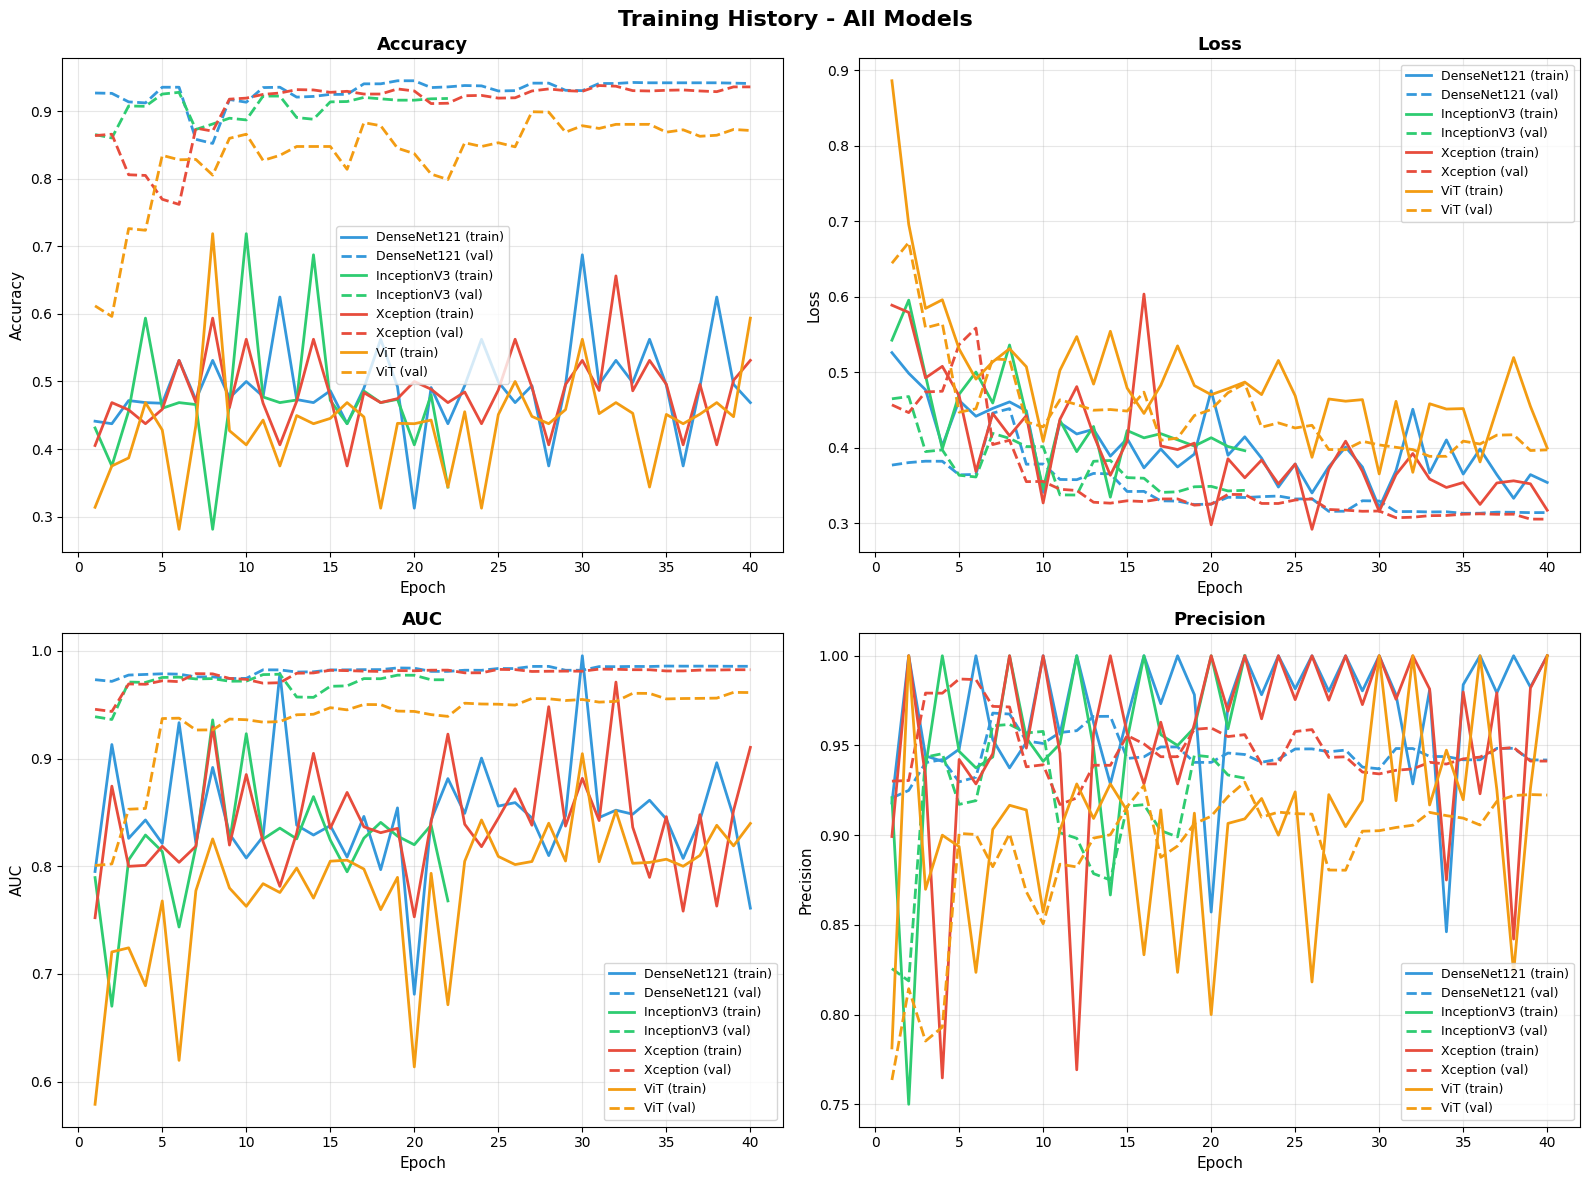

✓ Training history saved



In [13]:
ig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = [('accuracy', 'Accuracy'), ('loss', 'Loss'), 
           ('auc', 'AUC'), ('precision', 'Precision')]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (metric, title) in enumerate(metrics):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    for model_idx, (name, hist) in enumerate(training_results.items()):
        if metric in hist:
            epochs = range(1, len(hist[metric]) + 1)
            ax.plot(epochs, hist[metric], 
                   label=f'{name} (train)',
                   color=colors[model_idx], linestyle='-', linewidth=2)
            
            val_metric = f'val_{metric}'
            if val_metric in hist:
                ax.plot(epochs, hist[val_metric],
                       label=f'{name} (val)',
                       color=colors[model_idx], linestyle='--', linewidth=2)
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Training History - All Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(Config.FIGURES_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Training history saved\n")

### SECTION 6: CLASSIFICATION RESULTS

#### 6.1 Evaluation Function

In [14]:
def evaluate_model_complete(model, test_gen, model_name):
    """Complete model evaluation with improved handling"""
    
    print(f"\n{'='*80}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*80}\n")
    
    # Reset generator
    test_gen.reset()
    
    # Get predictions - handle different batch sizes
    predictions = []
    y_true = []
    
    steps = len(test_gen)
    for i in range(steps):
        x_batch, y_batch = test_gen[i]
        pred_batch = model.predict(x_batch, verbose=0)
        predictions.extend(pred_batch.flatten())
        y_true.extend(y_batch)
    
    predictions = np.array(predictions)
    y_true = np.array(y_true)
    y_pred = (predictions > 0.5).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc = auc(fpr, tpr)
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Results:")
    print(f"  Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC:       {roc_auc:.4f}")
    print(f"{'='*80}\n")
    
    return {
        'model_name': model_name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'auc': roc_auc,
        'cm': cm,
        'predictions': predictions,
        'y_true': y_true,
        'y_pred': y_pred,
        'fpr': fpr,
        'tpr': tpr
    }

print("✓ Evaluation function ready\n")

✓ Evaluation function ready



#### 6.2 Evaluate All Models

In [15]:
import gc

print("\n" + "#"*80)
print("# EVALUATION PHASE")
print("#"*80 + "\n")

evaluation_results = {}

for model_name in Config.MODELS_TO_TRAIN:
    model_path = Config.MODEL_DIR / f'{model_name}_best.h5'
    
    # Load model with custom objects if needed
    if model_name == 'ViT':
        custom_objects = {'Patches': Patches, 'PatchEncoder': PatchEncoder}
    else:
        custom_objects = {}
    
    try:
        model = keras.models.load_model(model_path, custom_objects=custom_objects)
    except Exception as e:
        print(f"Error loading {model_name}: {e}")
        continue
    
    # Get correct image size
    if model_name == 'ViT':
        img_size = Config.MODEL_CONFIG['ViT']['img_size']
    else:
        img_size = Config.MODEL_CONFIG[model_name]['img_size']
    
    # Create test generator WITHOUT mixup
    _, test_gen = create_generators(img_size, use_mixup=False)
    
    # Evaluate
    results = evaluate_model_complete(model, test_gen, model_name)
    evaluation_results[model_name] = results
    
    # Clean up
    del model, test_gen
    keras.backend.clear_session()
    gc.collect()

print("="*80)
print("ALL MODELS EVALUATED")
print("="*80 + "\n")



################################################################################
# EVALUATION PHASE
################################################################################



Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

EVALUATING: DenseNet121

Results:
  Accuracy:  0.9410 (94.10%)
  Precision: 0.9428
  Recall:    0.9390
  F1-Score:  0.9409
  AUC:       0.9849



Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

EVALUATING: InceptionV3

Results:
  Accuracy:  0.9225 (92.25%)
  Precision: 0.8997
  Recall:    0.9510
  F1-Score:  0.9246
  AUC:       0.9781



Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

EVALUATING: Xception

Results:
  Accuracy:  0.9365 (93.65%)
  Precision: 0.9369
  Recall:    0.9360
  F1-Score:  0.9365
  AUC:       0.9827



Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

EVALUATING: ViT

Results:
  Accuracy:  0.8720 (87.20%)
  Precision: 0.9237
  Recall:    0.8110
  F1-Score:  0.8637
  AUC:       0.9614

ALL MODELS EVALUATED



#### 6.3 Table 2: Individual Model Performance

In [16]:
def generate_table_2():
    """Table 2: Performance results from Transfer Learning"""
    
    data = {
        'Models': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-Score': []
    }
    
    for name, res in evaluation_results.items():
        data['Models'].append(name)
        data['Accuracy'].append(f"{res['accuracy']*100:.2f}%")
        data['Precision'].append(f"{res['precision']*100:.2f}%")
        data['Recall'].append(f"{res['recall']*100:.2f}%")
        data['F1-Score'].append(f"{res['f1_score']*100:.2f}%")
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("TABLE 2: PERFORMANCE RESULTS FROM TRANSFER LEARNING")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80 + "\n")
    
    df.to_csv(Config.RESULTS_DIR / 'table_2_transfer_learning.csv', index=False)
    
    return df

table_2 = generate_table_2()


TABLE 2: PERFORMANCE RESULTS FROM TRANSFER LEARNING
     Models Accuracy Precision Recall F1-Score
DenseNet121   94.10%    94.28% 93.90%   94.09%
InceptionV3   92.25%    89.97% 95.10%   92.46%
   Xception   93.65%    93.69% 93.60%   93.65%
        ViT   87.20%    92.37% 81.10%   86.37%



#### 6.4 Figure 9: Confusion Matrices (4 Models)

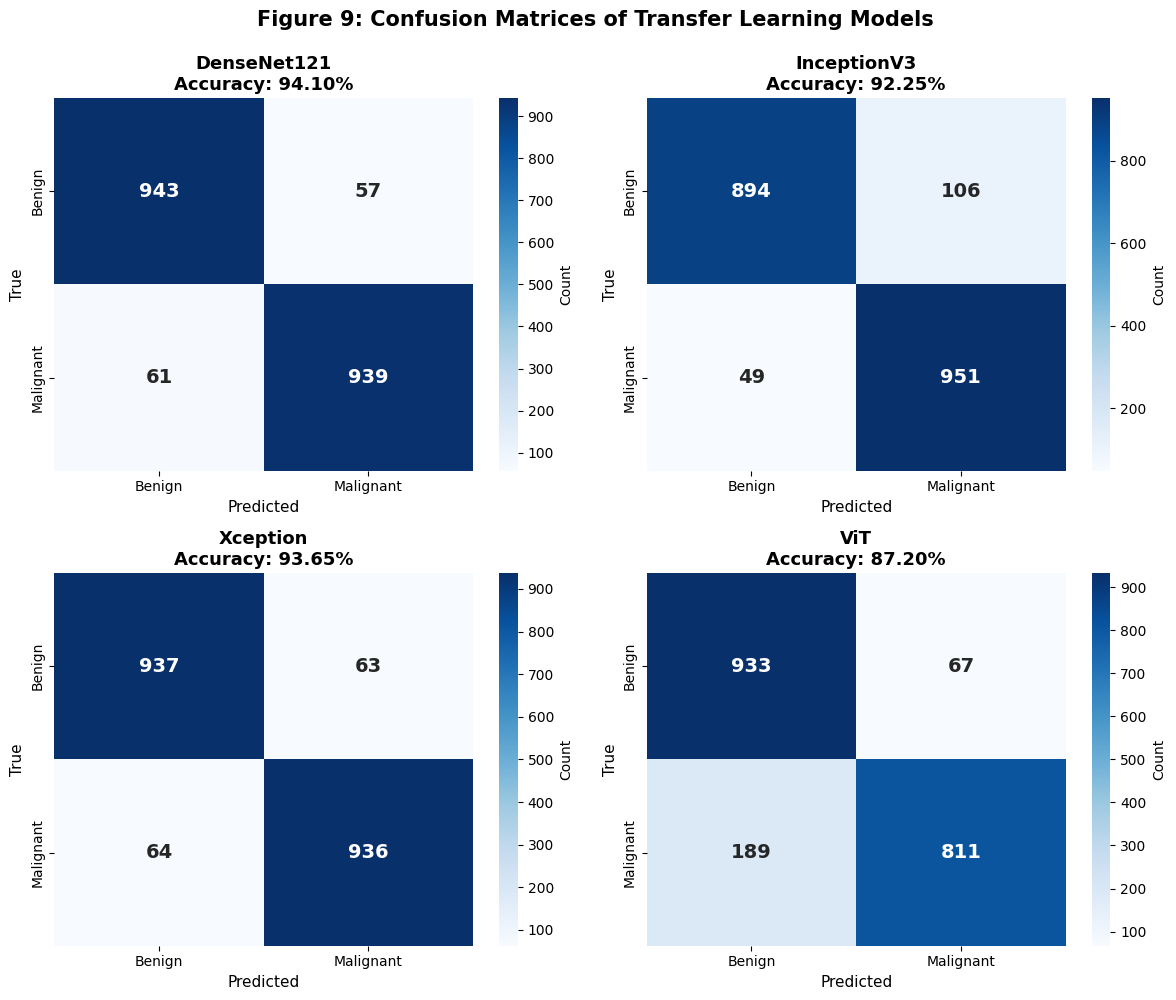

✓ Figure 9 saved



In [17]:
n_models = len(evaluation_results)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (name, res) in enumerate(evaluation_results.items()):
    if idx >= 4:  # Only plot first 4 models
        break
    
    ax = axes[idx]
    cm = res['cm']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
               xticklabels=Config.CLASSES,
               yticklabels=Config.CLASSES,
               annot_kws={'size': 14, 'weight': 'bold'},
               cbar_kws={'label': 'Count'})
    
    ax.set_title(f"{name}\nAccuracy: {res['accuracy']*100:.2f}%",
                fontsize=13, fontweight='bold')
    ax.set_ylabel('True', fontsize=11)
    ax.set_xlabel('Predicted', fontsize=11)

# Hide unused subplots
for idx in range(n_models, 4):
    axes[idx].axis('off')

plt.suptitle('Figure 9: Confusion Matrices of Transfer Learning Models', 
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(Config.FIGURES_DIR / 'figure_9_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Figure 9 saved\n")

#### 6.5 Figure 10: ROC Curves (4 Models)

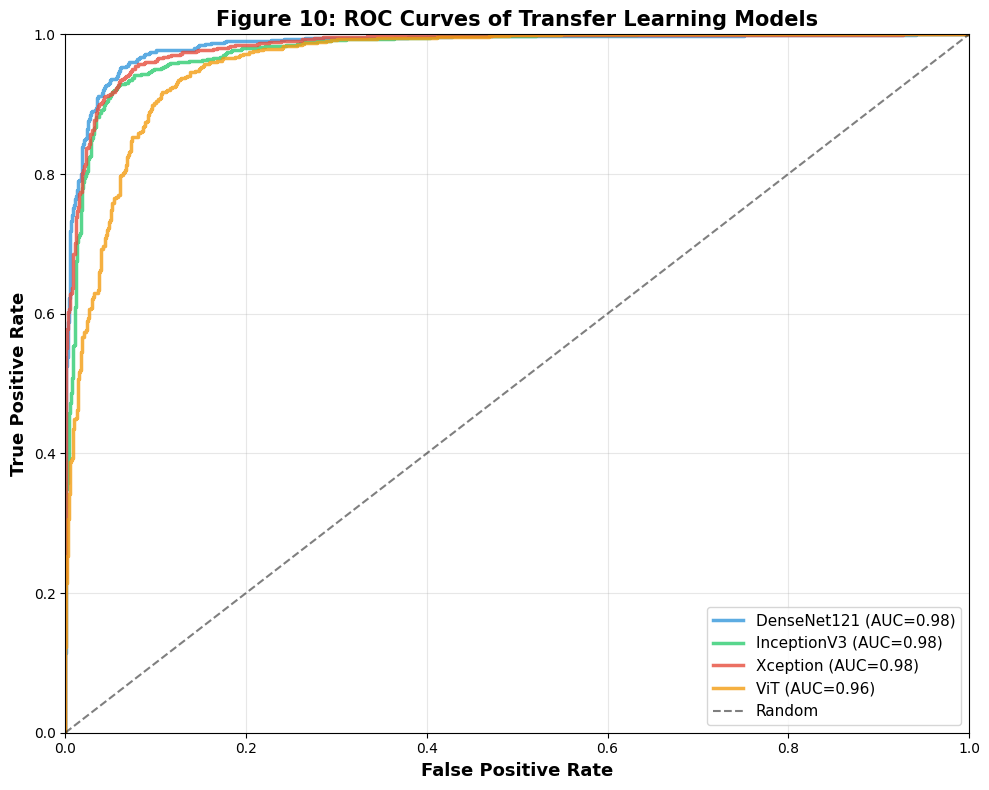

✓ Figure 10 saved



In [18]:
plt.figure(figsize=(10, 8))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (name, res) in enumerate(evaluation_results.items()):
    color = colors[idx % len(colors)]
    plt.plot(res['fpr'], res['tpr'],
            label=f"{name} (AUC={res['auc']:.2f})",
            color=color, linewidth=2.5, alpha=0.8)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random')
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('Figure 10: ROC Curves of Transfer Learning Models', 
         fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.savefig(Config.FIGURES_DIR / 'figure_10_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Figure 10 saved\n")

#### 6.6 Ensemble Optimization with Random Search

In [19]:
def optimize_ensemble_weights(predictions_dict, y_true, n_trials=2000, early_stop=100):
    """Random Search for optimal ensemble weights"""
    
    print("\n" + "="*80)
    print("ENSEMBLE WEIGHT OPTIMIZATION (Random Search)")
    print("="*80)
    print(f"Trials: {n_trials}, Early stopping: {early_stop}\n")
    
    model_names = list(predictions_dict.keys())
    n_models = len(model_names)
    
    best_weights = None
    best_auc = 0
    no_improvement = 0
    
    for trial in tqdm(range(n_trials), desc="Optimizing"):
        # Generate random weights
        weights = np.random.uniform(0, 1, n_models)
        weights = weights / np.sum(weights)
        
        # Calculate ensemble predictions
        ensemble_pred = np.zeros_like(predictions_dict[model_names[0]])
        for name, weight in zip(model_names, weights):
            ensemble_pred += predictions_dict[name] * weight
        
        # Calculate AUC
        fpr, tpr, _ = roc_curve(y_true, ensemble_pred)
        auc_score = auc(fpr, tpr)
        
        # Update best if improved
        if auc_score > best_auc:
            best_auc = auc_score
            best_weights = weights.copy()
            no_improvement = 0
        else:
            no_improvement += 1
        
        # Early stopping
        if no_improvement >= early_stop:
            print(f"\nEarly stopping at trial {trial+1}")
            break
    
    weight_dict = dict(zip(model_names, best_weights))
    
    print(f"\nOptimization complete!")
    print(f"Best AUC: {best_auc:.4f}")
    print(f"\nOptimal Weights:")
    for name, weight in weight_dict.items():
        print(f"  {name:20s}: {weight:.4f}")
    print("="*80 + "\n")
    
    return weight_dict, best_auc

# Prepare predictions dictionary
predictions_dict = {
    name: res['predictions'] 
    for name, res in evaluation_results.items()
}
y_true = list(evaluation_results.values())[0]['y_true']

# Optimize weights
optimal_weights, optimal_auc = optimize_ensemble_weights(
    predictions_dict, 
    y_true,
    n_trials=Config.RANDOM_SEARCH_TRIALS,
    early_stop=Config.EARLY_STOP_PATIENCE
)

# Create ensemble predictions
ensemble_preds = np.zeros_like(y_true, dtype=float)
for name, weight in optimal_weights.items():
    ensemble_preds += evaluation_results[name]['predictions'] * weight

y_pred_ens = (ensemble_preds > 0.5).astype(int)

# Calculate ensemble metrics
acc_ens = accuracy_score(y_true, y_pred_ens)
prec_ens = precision_score(y_true, y_pred_ens, zero_division=0)
rec_ens = recall_score(y_true, y_pred_ens, zero_division=0)
f1_ens = f1_score(y_true, y_pred_ens, zero_division=0)
fpr_ens, tpr_ens, _ = roc_curve(y_true, ensemble_preds)
auc_ens = auc(fpr_ens, tpr_ens)
cm_ens = confusion_matrix(y_true, y_pred_ens)

print(f"OPTIMIZED ENSEMBLE RESULTS:")
print(f"  Accuracy:  {acc_ens:.4f} ({acc_ens*100:.2f}%)")
print(f"  Precision: {prec_ens:.4f}")
print(f"  Recall:    {rec_ens:.4f}")
print(f"  F1-Score:  {f1_ens:.4f}")
print(f"  AUC:       {auc_ens:.4f}\n")

# Store ensemble results
evaluation_results['Ensemble'] = {
    'model_name': 'Ensemble',
    'accuracy': acc_ens,
    'precision': prec_ens,
    'recall': rec_ens,
    'f1_score': f1_ens,
    'auc': auc_ens,
    'cm': cm_ens,
    'predictions': ensemble_preds,
    'y_true': y_true,
    'y_pred': y_pred_ens,
    'fpr': fpr_ens,
    'tpr': tpr_ens,
    'weights': optimal_weights
}


ENSEMBLE WEIGHT OPTIMIZATION (Random Search)
Trials: 2000, Early stopping: 100



Optimizing:  12%|█▏        | 238/2000 [00:00<00:01, 949.24it/s]


Early stopping at trial 239

Optimization complete!
Best AUC: 0.9893

Optimal Weights:
  DenseNet121         : 0.4587
  InceptionV3         : 0.0906
  Xception            : 0.2816
  ViT                 : 0.1691

OPTIMIZED ENSEMBLE RESULTS:
  Accuracy:  0.9480 (94.80%)
  Precision: 0.9525
  Recall:    0.9430
  F1-Score:  0.9477
  AUC:       0.9893



# ### 6.7 Figure 11: Ensemble Confusion Matrix & ROC

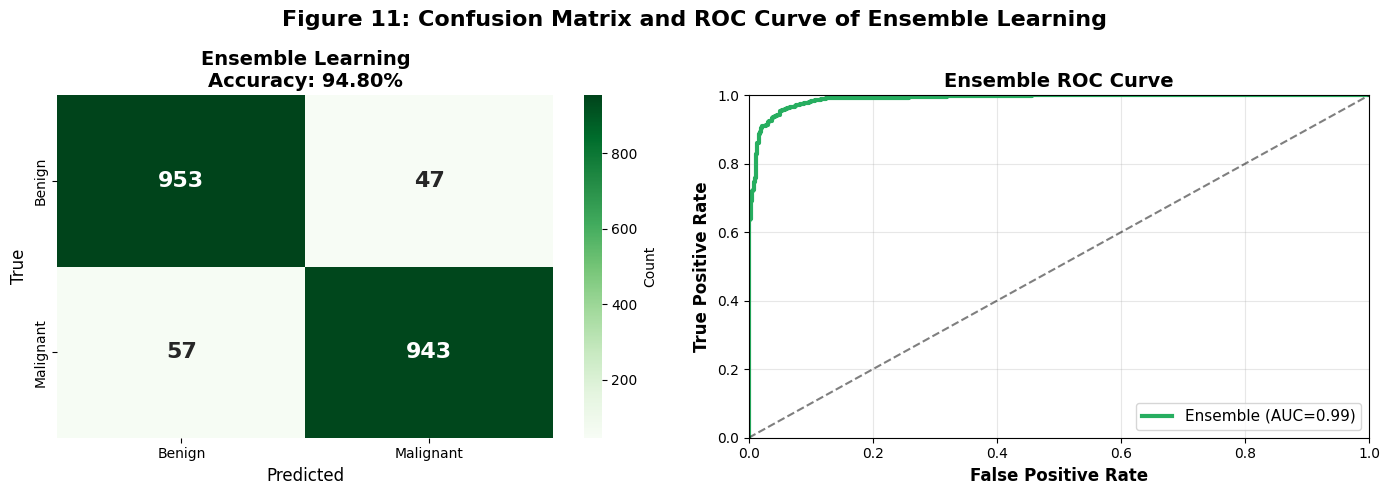

✓ Figure 11 saved



In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
res_ens = evaluation_results['Ensemble']

# Confusion Matrix
sns.heatmap(res_ens['cm'], annot=True, fmt='d', cmap='Greens', ax=axes[0],
           xticklabels=Config.CLASSES,
           yticklabels=Config.CLASSES,
           annot_kws={'size': 16, 'weight': 'bold'},
           cbar_kws={'label': 'Count'})
axes[0].set_title(f"Ensemble Learning\nAccuracy: {res_ens['accuracy']*100:.2f}%",
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('True', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

# ROC Curve
axes[1].plot(res_ens['fpr'], res_ens['tpr'],
            color='#27ae60', linewidth=3,
            label=f"Ensemble (AUC={res_ens['auc']:.2f})")
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5)
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('Ensemble ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.suptitle('Figure 11: Confusion Matrix and ROC Curve of Ensemble Learning', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(Config.FIGURES_DIR / 'figure_11_ensemble_results.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Figure 11 saved\n")

# ### 6.8 Table 3: Ensemble Performance

In [21]:
def generate_table_3():
    """Table 3: Ensemble Performance"""
    
    res_ens = evaluation_results['Ensemble']
    
    data = {
        'Model': ['Ensemble learning'],
        'Accuracy': [f"{res_ens['accuracy']*100:.2f}%"],
        'Precision': [f"{res_ens['precision']*100:.2f}%"],
        'Recall': [f"{res_ens['recall']*100:.2f}%"],
        'F1-Score': [f"{res_ens['f1_score']*100:.2f}%"]
    }
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("TABLE 3: ENSEMBLE LEARNING PERFORMANCE")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80 + "\n")
    
    df.to_csv(Config.RESULTS_DIR / 'table_3_ensemble.csv', index=False)
    
    return df

table_3 = generate_table_3()


TABLE 3: ENSEMBLE LEARNING PERFORMANCE
            Model Accuracy Precision Recall F1-Score
Ensemble learning   94.80%    95.25% 94.30%   94.77%



### SECTION 7: CBIR - INDIVIDUAL MODELS

#### 7.1 Feature Extraction

In [22]:
print("\n" + "#"*80)
print("# CBIR PHASE 1: FEATURE EXTRACTION")
print("#"*80 + "\n")

def extract_features_for_cbir(model_name):
    """Extract features for CBIR with improved error handling"""
    
    print(f"\nExtracting features: {model_name}")
    
    model_path = Config.MODEL_DIR / f'{model_name}_best.h5'
    
    # Load model
    if model_name == 'ViT':
        custom_objects = {'Patches': Patches, 'PatchEncoder': PatchEncoder}
    else:
        custom_objects = {}
    
    try:
        model = keras.models.load_model(model_path, custom_objects=custom_objects)
    except Exception as e:
        print(f"  Error loading model: {e}")
        return None, None, None
    
    # Get image size
    if model_name == 'ViT':
        img_size = Config.MODEL_CONFIG['ViT']['img_size']
    else:
        img_size = Config.MODEL_CONFIG[model_name]['img_size']
    
    # Create feature extraction model
    try:
        feature_model = keras.Model(
            inputs=model.input,
            outputs=model.get_layer('feature_layer').output
        )
        print(f"  ✓ Using 'feature_layer'")
    except:
        print(f"  'feature_layer' not found, using fallback")
        # Use layer before final Dense
        for layer in reversed(model.layers):
            if isinstance(layer, layers.Dense) and layer.units != 1:
                feature_model = keras.Model(
                    inputs=model.input,
                    outputs=layer.output
                )
                print(f"  ✓ Using layer: {layer.name}")
                break
    
    # Create test generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_directory(
        Config.TEST_DIR,
        target_size=(img_size, img_size),
        batch_size=Config.BATCH_SIZE,
        class_mode=Config.CLASS_MODE,
        shuffle=False
    )
    
    print(f"  Extracting from {len(test_gen.filenames)} images...")
    
    # Extract features batch by batch (more stable)
    features_list = []
    steps = len(test_gen)
    
    for i in range(steps):
        x_batch, _ = test_gen[i]
        feat_batch = feature_model.predict(x_batch, verbose=0)
        features_list.append(feat_batch)
    
    features = np.vstack(features_list)
    labels = test_gen.classes
    filenames = test_gen.filenames
    
    # Save features
    feature_file = Config.FEATURES_DIR / f'{model_name}_features.npz'
    np.savez_compressed(feature_file, 
                       features=features, 
                       labels=labels, 
                       filenames=filenames)
    
    print(f"  ✓ Features: {features.shape}")
    print(f"  ✓ Saved: {feature_file.name}")
    
    # Cleanup
    del model, feature_model, test_gen
    keras.backend.clear_session()
    gc.collect()
    
    return features, labels, filenames

# Extract features for all models
cbir_features = {}
cbir_labels = None
cbir_filenames = None

for model_name in Config.MODELS_TO_TRAIN:
    features, labels, filenames = extract_features_for_cbir(model_name)
    
    if features is not None:
        cbir_features[model_name] = features
        
        if cbir_labels is None:
            cbir_labels = labels
            cbir_filenames = filenames

print("\n✓ Feature extraction complete\n")


################################################################################
# CBIR PHASE 1: FEATURE EXTRACTION
################################################################################


Extracting features: DenseNet121


  ✓ Using 'feature_layer'
Found 2000 images belonging to 2 classes.
  Extracting from 2000 images...
  ✓ Features: (2000, 256)
  ✓ Saved: DenseNet121_features.npz

Extracting features: InceptionV3


  ✓ Using 'feature_layer'
Found 2000 images belonging to 2 classes.
  Extracting from 2000 images...
  ✓ Features: (2000, 256)
  ✓ Saved: InceptionV3_features.npz

Extracting features: Xception


  ✓ Using 'feature_layer'
Found 2000 images belonging to 2 classes.
  Extracting from 2000 images...
  ✓ Features: (2000, 256)
  ✓ Saved: Xception_features.npz

Extracting features: ViT


  ✓ Using 'feature_layer'
Found 2000 images belonging to 2 classes.
  Extracting from 2000 images...
  ✓ Features: (2000, 256)
  ✓ Saved: ViT_features.npz

✓ Feature extraction complete



#### 7.2 CBIR Evaluation (Individual)

In [23]:
def calculate_average_precision(retrieved_labels, query_label, k=5):
    """Calculate Average Precision for a single query"""
    relevant = 0
    precision_sum = 0.0
    
    for i, label in enumerate(retrieved_labels[:k], 1):
        if label == query_label:
            relevant += 1
            precision_sum += relevant / i
    
    if relevant == 0:
        return 0.0
    
    return precision_sum / min(k, relevant)


def cbir_evaluate_model(features, labels, model_name, num_queries=20, top_k=5):
    """Evaluate CBIR performance with improved stability"""
    
    print(f"\nEvaluating CBIR: {model_name}")
    
    # Normalize features
    features_norm = normalize(features, axis=1)
    
    # Select random queries
    np.random.seed(SEED)
    query_indices = np.random.choice(len(features), num_queries, replace=False)
    
    ap_scores = []
    
    for query_idx in query_indices:
        query_feat = features_norm[query_idx].reshape(1, -1)
        query_label = labels[query_idx]
        
        # Calculate similarities
        similarities = cosine_similarity(query_feat, features_norm)[0]
        
        # Sort by similarity (exclude query itself)
        sorted_indices = np.argsort(similarities)[::-1]
        sorted_indices = sorted_indices[sorted_indices != query_idx]
        
        # Get top-k
        top_k_indices = sorted_indices[:top_k]
        top_k_labels = labels[top_k_indices]
        
        # Calculate AP
        ap = calculate_average_precision(top_k_labels, query_label, top_k)
        ap_scores.append(ap)
    
    mean_ap = np.mean(ap_scores)
    
    print(f"  mAP@{top_k}: {mean_ap:.4f}")
    
    return {
        'model_name': model_name,
        'mAP': mean_ap,
        'ap_scores': ap_scores,
        'num_queries': num_queries
    }


# Evaluate all models
cbir_results = {}

for model_name in Config.MODELS_TO_TRAIN:
    if model_name in cbir_features:
        result = cbir_evaluate_model(
            cbir_features[model_name],
            cbir_labels,
            model_name,
            num_queries=Config.NUM_CBIR_QUERIES,
            top_k=Config.TOP_K_RETRIEVAL
        )
        cbir_results[model_name] = result

print("\n✓ Individual CBIR evaluation complete\n")


Evaluating CBIR: DenseNet121
  mAP@5: 1.0000

Evaluating CBIR: InceptionV3
  mAP@5: 0.9975

Evaluating CBIR: Xception
  mAP@5: 0.9780

Evaluating CBIR: ViT
  mAP@5: 0.8819

✓ Individual CBIR evaluation complete



#### 7.3 Table 4: Individual CBIR Performance

In [24]:
def generate_table_4():
    """Table 4: CBIR Performance (Individual)"""
    
    data = {
        'Models': [],
        'Mean Average Precision (mAP)': []
    }
    
    for name, res in cbir_results.items():
        data['Models'].append(name)
        data['Mean Average Precision (mAP)'].append(f"{res['mAP']:.4f}")
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("TABLE 4: CBIR PERFORMANCE (INDIVIDUAL MODELS)")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80 + "\n")
    
    df.to_csv(Config.RESULTS_DIR / 'table_4_cbir_individual.csv', index=False)
    
    return df

table_4 = generate_table_4()


TABLE 4: CBIR PERFORMANCE (INDIVIDUAL MODELS)
     Models Mean Average Precision (mAP)
DenseNet121                       1.0000
InceptionV3                       0.9975
   Xception                       0.9780
        ViT                       0.8819



#### 7.4 Figure 12: CBIR Precision-Recall Curves (Individual)

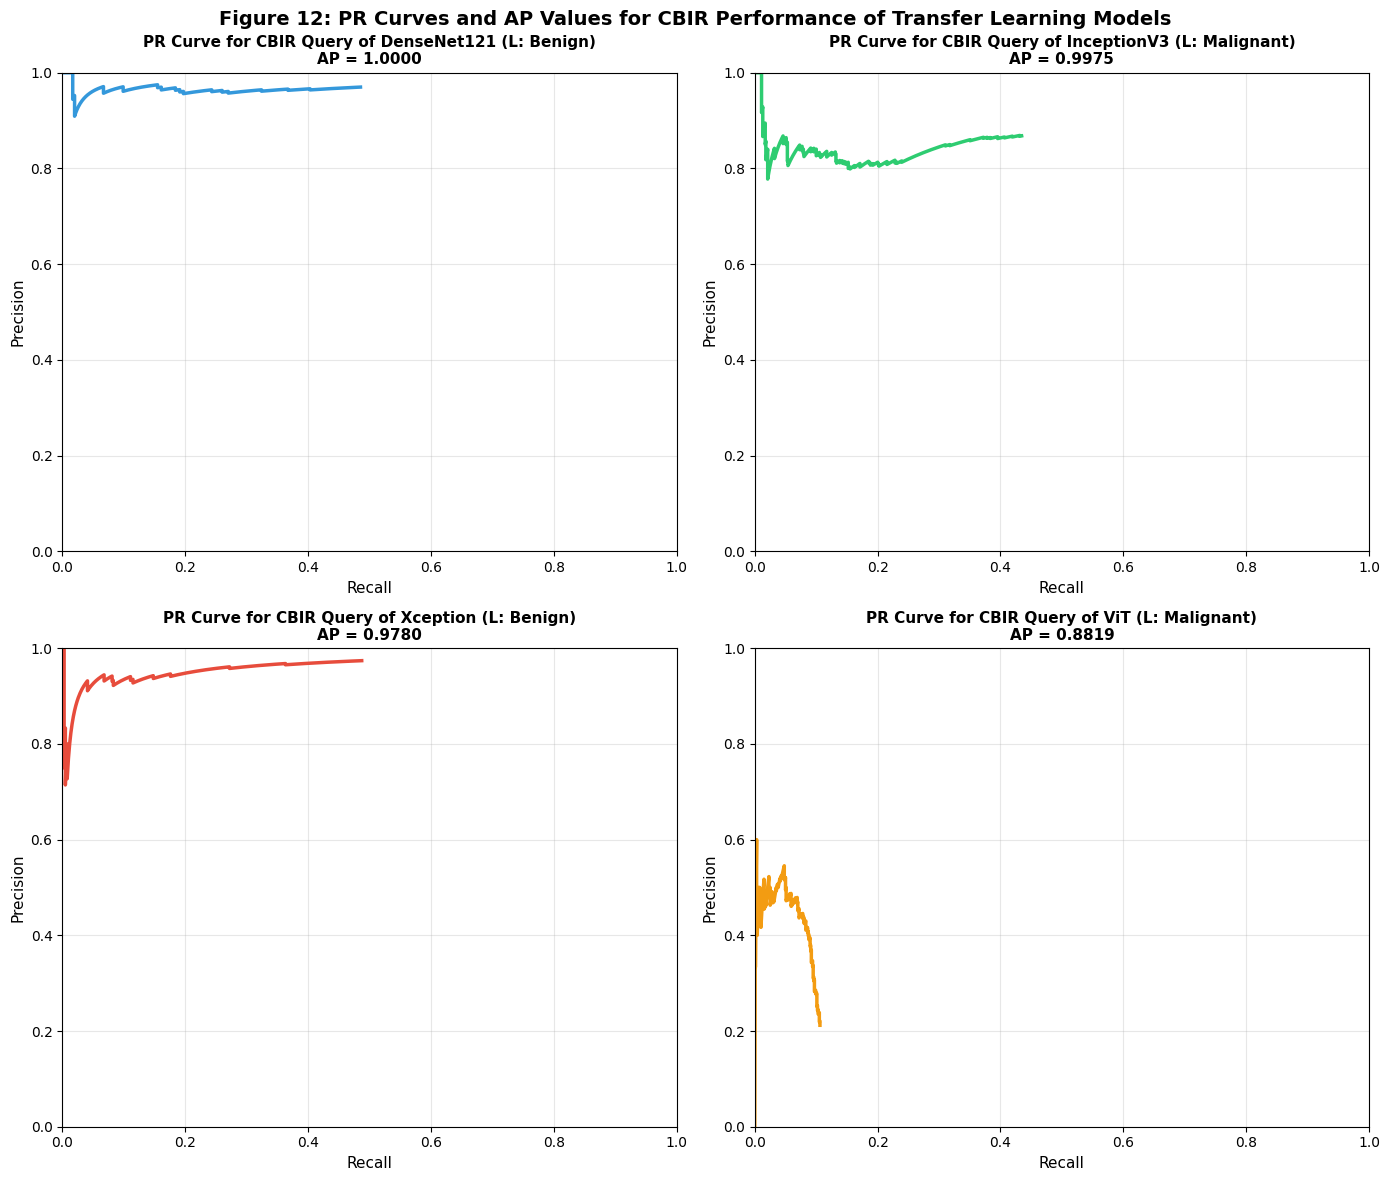

✓ Figure 12 saved



In [25]:
def calculate_pr_curve_cbir(features, labels, model_name, query_idx=None):
    """Calculate Precision-Recall curve for CBIR"""
    
    features_norm = normalize(features, axis=1)
    
    # Use provided query or random
    if query_idx is None:
        np.random.seed(SEED)
        query_idx = np.random.choice(len(features))
    
    query_feat = features_norm[query_idx].reshape(1, -1)
    query_label = labels[query_idx]
    
    # Calculate similarities
    similarities = cosine_similarity(query_feat, features_norm)[0]
    
    # Sort (exclude query)
    sorted_indices = np.argsort(similarities)[::-1]
    sorted_indices = sorted_indices[sorted_indices != query_idx]
    
    # Calculate PR curve
    precisions = []
    recalls = []
    
    total_relevant = np.sum(labels == query_label) - 1  # Exclude query
    
    if total_relevant == 0:
        return np.array([0, 1]), np.array([1, 0])
    
    relevant_so_far = 0
    max_k = min(len(sorted_indices), 500)  # Limit for performance
    
    for k in range(1, max_k + 1):
        retrieved_labels = labels[sorted_indices[:k]]
        relevant_so_far = np.sum(retrieved_labels == query_label)
        
        precision = relevant_so_far / k
        recall = relevant_so_far / total_relevant
        
        precisions.append(precision)
        recalls.append(recall)
    
    return np.array(recalls), np.array(precisions)


# Calculate PR curves for individual models
pr_curves_individual = {}

for name in Config.MODELS_TO_TRAIN:
    if name in cbir_features:
        recalls, precisions = calculate_pr_curve_cbir(
            cbir_features[name], 
            cbir_labels, 
            name
        )
        pr_curves_individual[name] = {'recall': recalls, 'precision': precisions}

# Plot Figure 12
n_models = len(pr_curves_individual)
n_rows = (n_models + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6*n_rows))
if n_models == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)

axes = axes.flatten()
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (name, data) in enumerate(pr_curves_individual.items()):
    ax = axes[idx]
    
    # Get AP value
    ap_value = cbir_results[name]['mAP']
    
    ax.plot(data['recall'], data['precision'], 
           linewidth=2.5, color=colors[idx % len(colors)])
    
    ax.set_xlabel('Recall', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    
    # Determine query class
    query_class = Config.CLASSES[idx % len(Config.CLASSES)]
    ax.set_title(f'PR Curve for CBIR Query of {name} (L: {query_class})\nAP = {ap_value:.4f}',
                fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

# Hide unused subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Figure 12: PR Curves and AP Values for CBIR Performance of Transfer Learning Models', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(Config.FIGURES_DIR / 'figure_12_cbir_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 12 saved\n")

#### 7.5 Figure 13: Top-5 Similar Images (Individual)

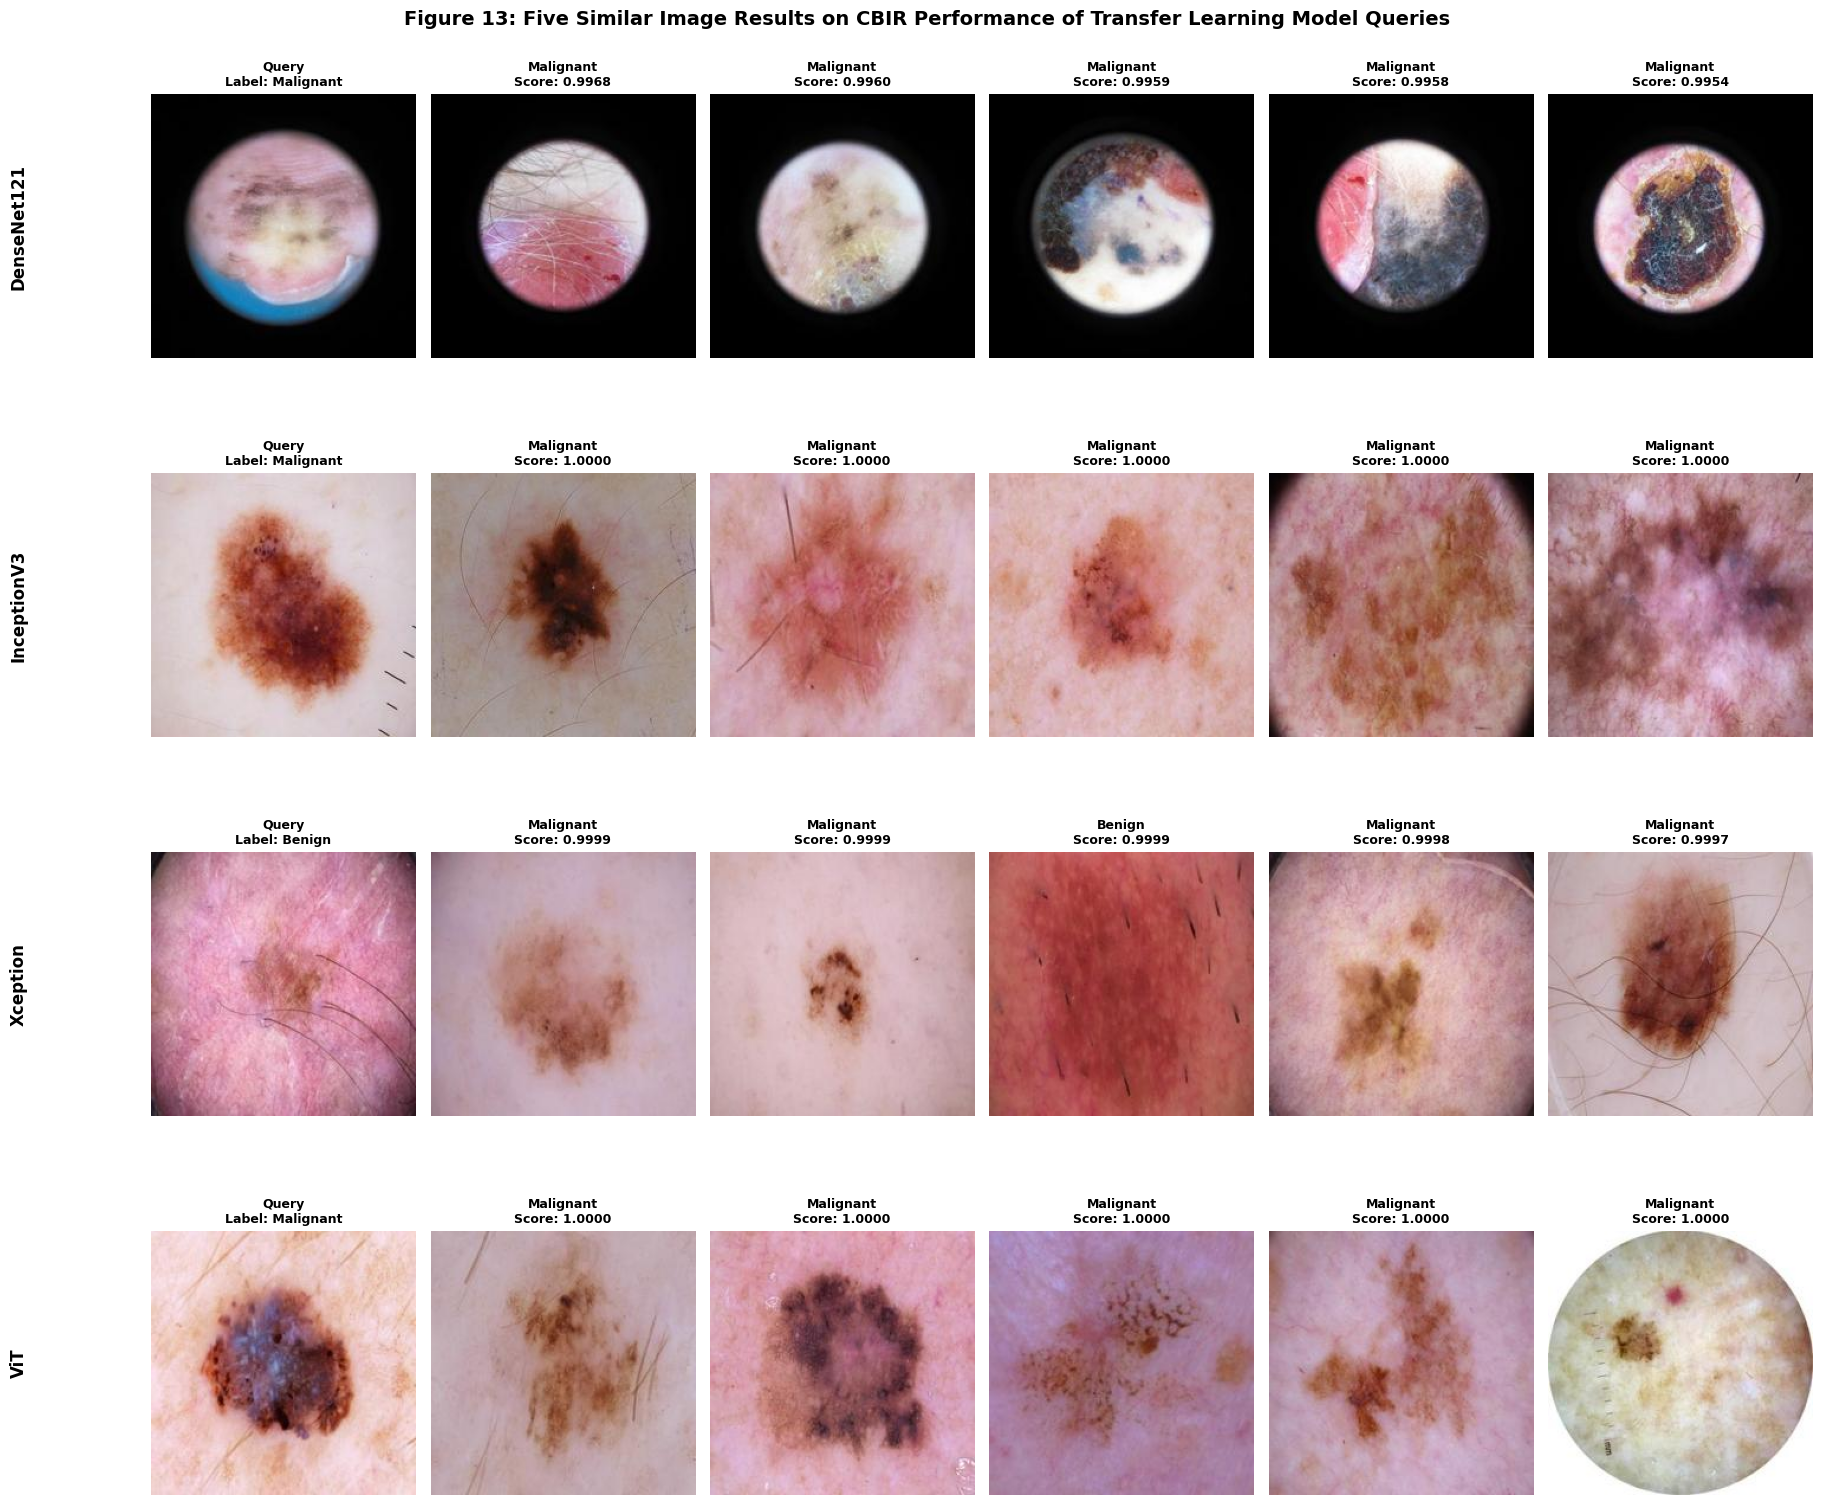

✓ Figure 13 saved



In [26]:
def visualize_cbir_top5_individual(features_dict, labels, filenames):
    """Visualize top-5 retrieval for each model"""
    
    n_models = len(features_dict)
    fig, axes = plt.subplots(n_models, 6, figsize=(18, 4*n_models))
    
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    np.random.seed(SEED + 10)
    
    for model_idx, model_name in enumerate(features_dict.keys()):
        features = features_dict[model_name]
        features_norm = normalize(features, axis=1)
        
        # Random query
        query_idx = np.random.choice(len(features))
        query_feat = features_norm[query_idx].reshape(1, -1)
        query_label = labels[query_idx]
        query_file = filenames[query_idx]
        
        # Calculate similarities
        similarities = cosine_similarity(query_feat, features_norm)[0]
        sorted_indices = np.argsort(similarities)[::-1]
        sorted_indices = sorted_indices[sorted_indices != query_idx]
        top5_indices = sorted_indices[:5]
        
        # Plot query image
        query_path = Config.TEST_DIR / query_file
        if query_path.exists():
            try:
                img = plt.imread(str(query_path))
                axes[model_idx, 0].imshow(img)
            except:
                axes[model_idx, 0].text(0.5, 0.5, 'Image\nError', 
                                       ha='center', va='center')
        
        axes[model_idx, 0].set_title(f'Query\nLabel: {Config.CLASSES[query_label]}',
                                    fontsize=9, fontweight='bold')
        axes[model_idx, 0].axis('off')
        
        # Plot top-5 results
        for j, idx in enumerate(top5_indices):
            result_file = filenames[idx]
            result_label = labels[idx]
            similarity = similarities[idx]
            
            result_path = Config.TEST_DIR / result_file
            if result_path.exists():
                try:
                    img = plt.imread(str(result_path))
                    axes[model_idx, j+1].imshow(img)
                except:
                    axes[model_idx, j+1].text(0.5, 0.5, 'Image\nError', 
                                             ha='center', va='center')
            
            axes[model_idx, j+1].set_title(
                f'{Config.CLASSES[result_label]}\nScore: {similarity:.4f}',
                fontsize=9, fontweight='bold'
            )
            axes[model_idx, j+1].axis('off')
        
        # Add model name label
        axes[model_idx, 0].text(-0.5, 0.5, model_name, 
                              transform=axes[model_idx, 0].transAxes,
                              fontsize=12, fontweight='bold', rotation=90,
                              ha='center', va='center')
    
    plt.suptitle('Figure 13: Five Similar Image Results on CBIR Performance of Transfer Learning Model Queries', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(Config.FIGURES_DIR / 'figure_13_cbir_top5_individual.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_cbir_top5_individual(cbir_features, cbir_labels, cbir_filenames)

print("✓ Figure 13 saved\n")

### SECTION 8: CBIR - MULTI-MODEL FUSION

#### 8.1 Multi-Model Feature Fusion

In [27]:
# Calculate fusion weights based on mAP
fusion_weights = {}
total_map = sum([r['mAP'] for r in cbir_results.values()])

if total_map == 0:
    print("Warning: Total mAP is 0, using equal weights")
    for name in cbir_results.keys():
        fusion_weights[name] = 1.0 / len(cbir_results)
else:
    print("Fusion Weights (based on CBIR mAP):")
    for name, res in cbir_results.items():
        weight = res['mAP'] / total_map
        fusion_weights[name] = weight
        print(f"  {name:20s}: {weight:.4f}")

# Normalize all features
normalized_features = {}
for name in cbir_features.keys():
    normalized_features[name] = normalize(cbir_features[name], axis=1)

# Create weighted fusion
print("\nCreating fused features...")
fused_features = []

for i in range(len(cbir_labels)):
    weighted_feat = np.concatenate([
        normalized_features[name][i] * fusion_weights[name]
        for name in cbir_features.keys()
    ])
    fused_features.append(weighted_feat)

fused_features = np.array(fused_features)
fused_features = normalize(fused_features, axis=1)

print(f"  Fused features shape: {fused_features.shape}")
print("✓ Feature fusion complete\n")

Fusion Weights (based on CBIR mAP):
  DenseNet121         : 0.2592
  InceptionV3         : 0.2586
  Xception            : 0.2535
  ViT                 : 0.2286

Creating fused features...
  Fused features shape: (2000, 1024)
✓ Feature fusion complete



#### 8.2 CBIR Evaluation (Multi-Model)

In [28]:
def cbir_evaluate_fusion(features, labels, num_queries=20, top_k=5):
    """Evaluate fusion CBIR performance"""
    
    print(f"\nEvaluating Multi-Model Fusion CBIR")
    
    np.random.seed(SEED)
    query_indices = np.random.choice(len(features), num_queries, replace=False)
    
    ap_scores = []
    
    for query_idx in query_indices:
        query_feat = features[query_idx].reshape(1, -1)
        query_label = labels[query_idx]
        
        similarities = cosine_similarity(query_feat, features)[0]
        
        sorted_indices = np.argsort(similarities)[::-1]
        sorted_indices = sorted_indices[sorted_indices != query_idx]
        top_k_indices = sorted_indices[:top_k]
        top_k_labels = labels[top_k_indices]
        
        ap = calculate_average_precision(top_k_labels, query_label, top_k)
        ap_scores.append(ap)
    
    mean_ap = np.mean(ap_scores)
    
    print(f"  mAP@{top_k}: {mean_ap:.4f}")
    
    return {
        'mAP': mean_ap,
        'ap_scores': ap_scores
    }

fusion_result = cbir_evaluate_fusion(
    fused_features, 
    cbir_labels, 
    Config.NUM_CBIR_QUERIES, 
    Config.TOP_K_RETRIEVAL
)

print("\n✓ Multi-model fusion CBIR complete\n")


Evaluating Multi-Model Fusion CBIR
  mAP@5: 0.9840

✓ Multi-model fusion CBIR complete



#### 8.3 Table 5: Multi-Model Fusion Performance

In [29]:
def generate_table_5():
    """Table 5: Multi-Model Fusion CBIR Performance"""
    
    data = {
        'Models': ['Multi-model fusion'],
        'Mean Average Precision (mAP)': [f"{fusion_result['mAP']:.4f}"]
    }
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("TABLE 5: MULTI-MODEL FUSION CBIR PERFORMANCE")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80 + "\n")
    
    df.to_csv(Config.RESULTS_DIR / 'table_5_cbir_fusion.csv', index=False)
    
    return df

table_5 = generate_table_5()


TABLE 5: MULTI-MODEL FUSION CBIR PERFORMANCE
            Models Mean Average Precision (mAP)
Multi-model fusion                       0.9840



#### 8.4 Figure 14: CBIR PR Curves (Multi-Model)


################################################################################
# CBIR PHASE 1: FEATURE EXTRACTION
################################################################################


Extracting features: DenseNet121


  ✓ Using 'feature_layer'
Found 2000 images belonging to 2 classes.
  Extracting from 2000 images...
  ✓ Features: (2000, 256)
  ✓ Saved: DenseNet121_features.npz

Extracting features: InceptionV3


  ✓ Using 'feature_layer'
Found 2000 images belonging to 2 classes.
  Extracting from 2000 images...
  ✓ Features: (2000, 256)
  ✓ Saved: InceptionV3_features.npz

Extracting features: Xception


  ✓ Using 'feature_layer'
Found 2000 images belonging to 2 classes.
  Extracting from 2000 images...
  ✓ Features: (2000, 256)
  ✓ Saved: Xception_features.npz

Extracting features: ViT


  ✓ Using 'feature_layer'
Found 2000 images belonging to 2 classes.
  Extracting from 2000 images...
  ✓ Features: (2000, 256)
  ✓ Saved: ViT_features.npz

✓ Feature extraction complete


Evaluating CBIR: DenseNet121
  mAP@5: 1.0000

Evaluating CBIR: InceptionV3
  mAP@5: 0.9975

Evaluating CBIR: Xception
  mAP@5: 0.9780

Evaluating CBIR: ViT
  mAP@5: 0.8819

✓ Individual CBIR evaluation complete


TABLE 4: CBIR PERFORMANCE (INDIVIDUAL MODELS)
     Models Mean Average Precision (mAP)
DenseNet121                       1.0000
InceptionV3                       0.9975
   Xception                       0.9780
        ViT                       0.8819



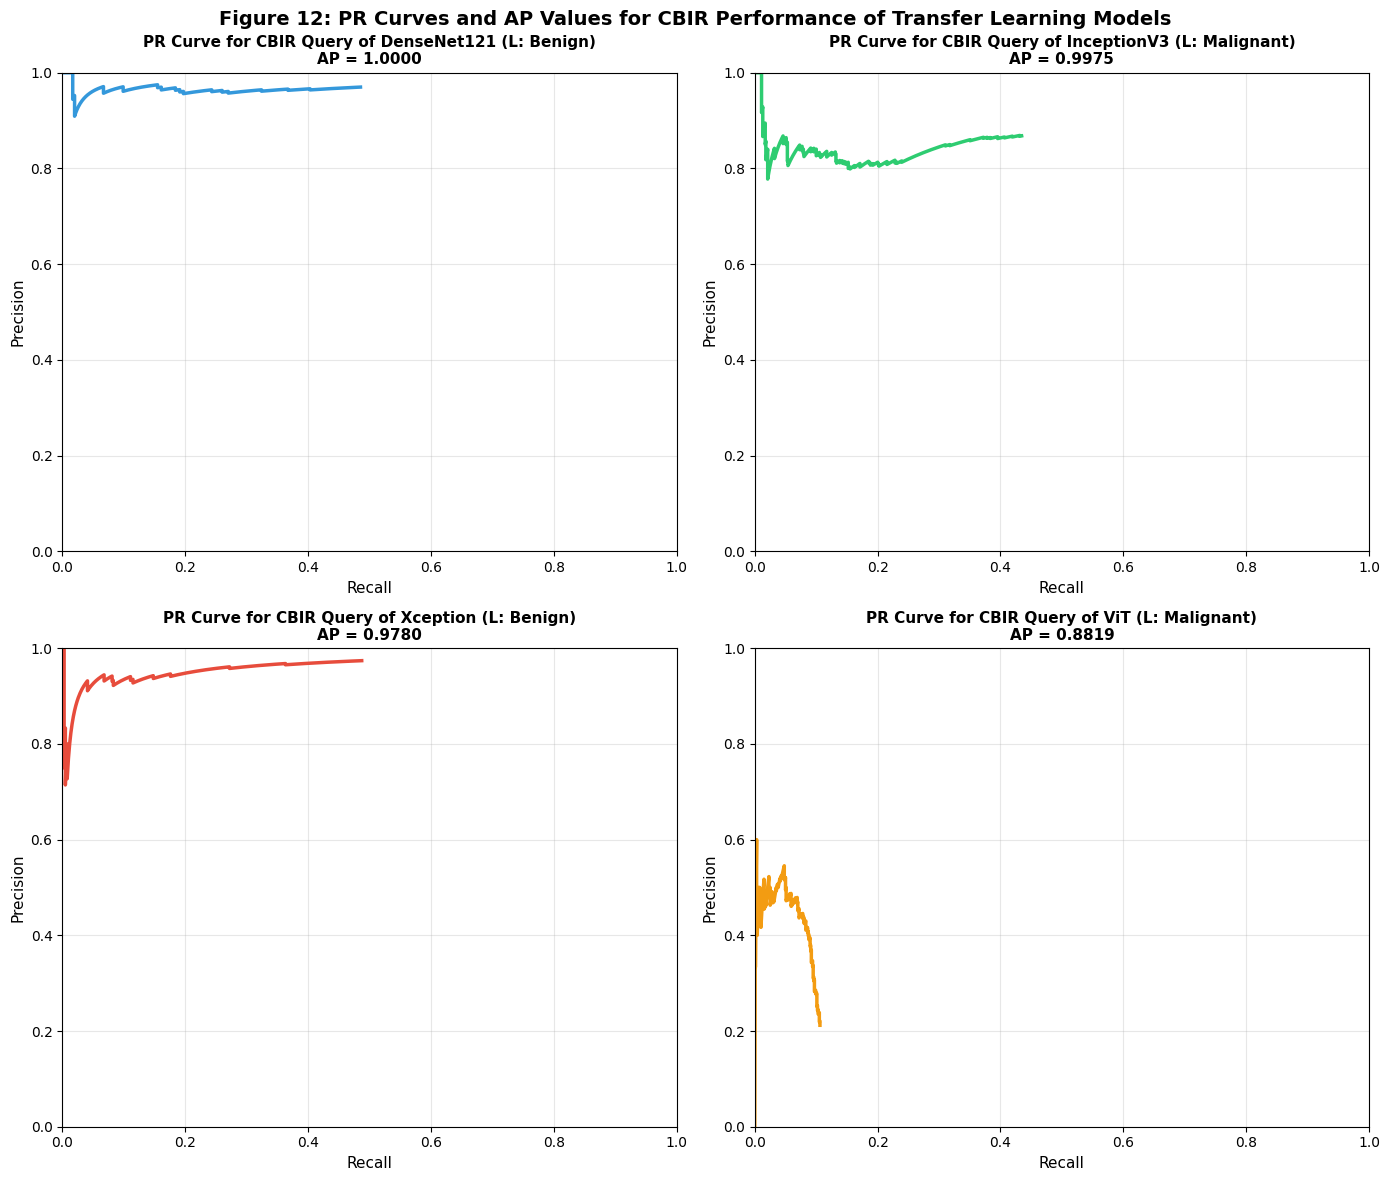

✓ Figure 12 saved



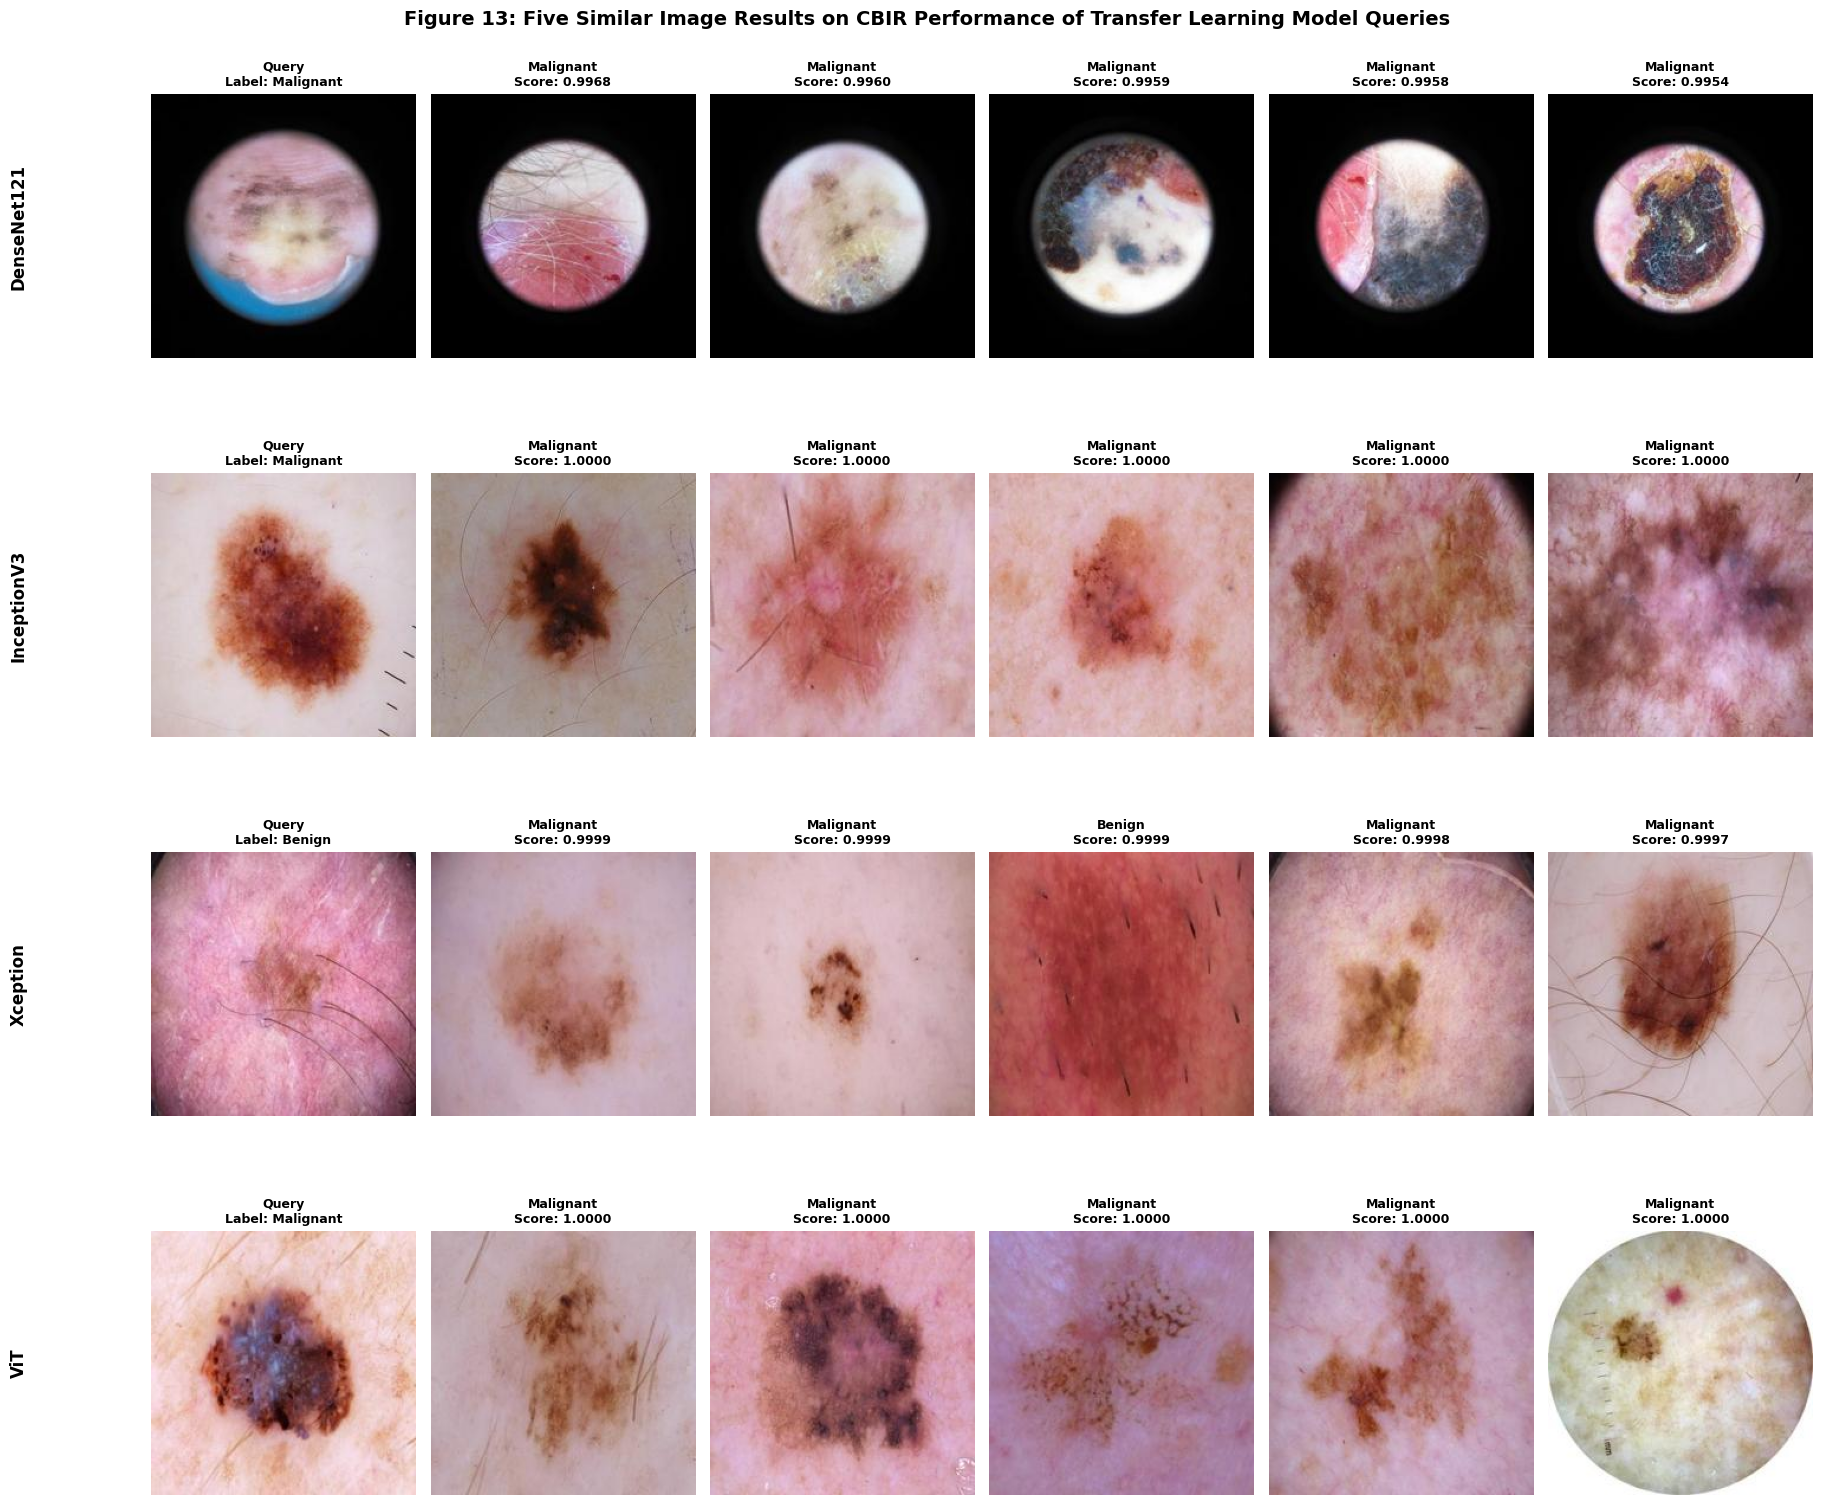

✓ Figure 13 saved


################################################################################
# CBIR PHASE 2: MULTI-MODEL FUSION
################################################################################

Fusion Weights (based on CBIR mAP):
  DenseNet121         : 0.2592
  InceptionV3         : 0.2586
  Xception            : 0.2535
  ViT                 : 0.2286

Creating fused features...
  Fused features shape: (2000, 1024)
✓ Feature fusion complete


Evaluating Multi-Model Fusion CBIR
  mAP@5: 0.9840

✓ Multi-model fusion CBIR complete


TABLE 5: MULTI-MODEL FUSION CBIR PERFORMANCE
            Models Mean Average Precision (mAP)
Multi-model fusion                       0.9840



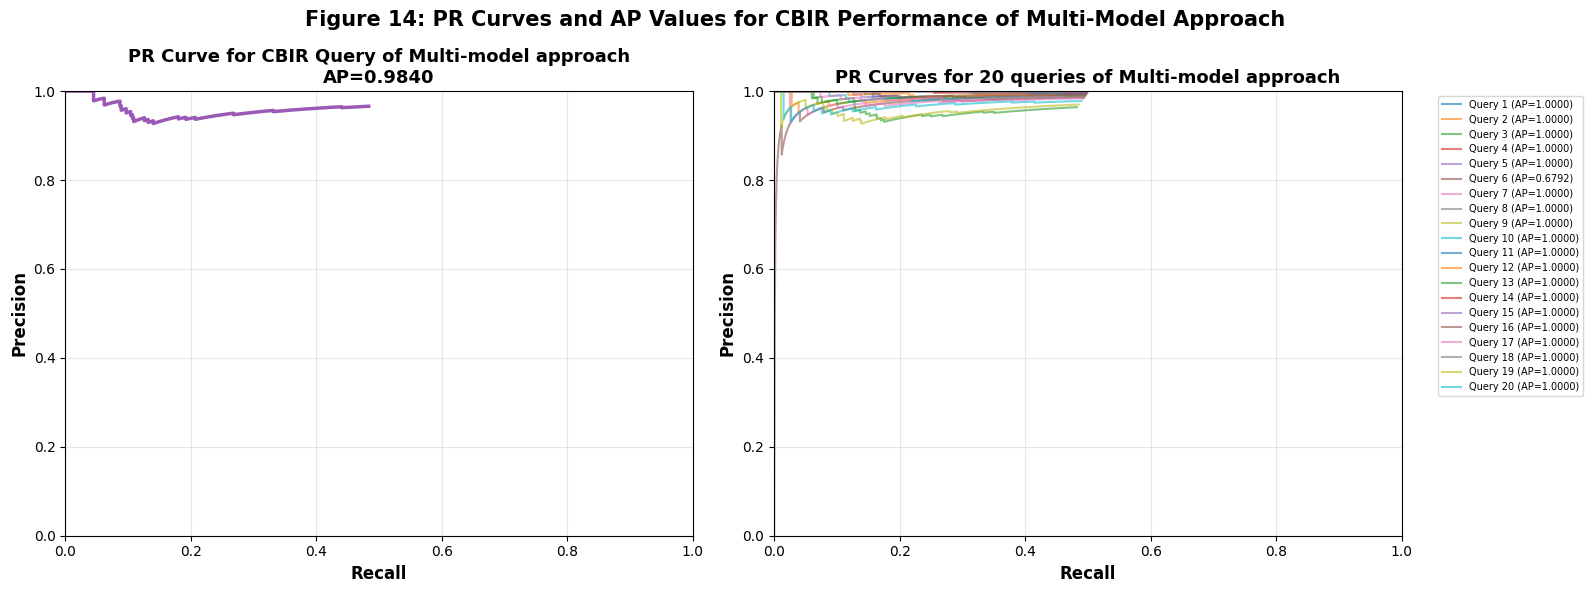

✓ Figure 14 saved



In [30]:
print("\n" + "#"*80)
print("# CBIR PHASE 1: FEATURE EXTRACTION")
print("#"*80 + "\n")

def extract_features_for_cbir(model_name):
    """Extract features for CBIR with improved error handling"""
    
    print(f"\nExtracting features: {model_name}")
    
    model_path = Config.MODEL_DIR / f'{model_name}_best.h5'
    
    # Load model
    if model_name == 'ViT':
        custom_objects = {'Patches': Patches, 'PatchEncoder': PatchEncoder}
    else:
        custom_objects = {}
    
    try:
        model = keras.models.load_model(model_path, custom_objects=custom_objects)
    except Exception as e:
        print(f"  Error loading model: {e}")
        return None, None, None
    
    # Get image size
    if model_name == 'ViT':
        img_size = Config.MODEL_CONFIG['ViT']['img_size']
    else:
        img_size = Config.MODEL_CONFIG[model_name]['img_size']
    
    # Create feature extraction model
    try:
        feature_model = keras.Model(
            inputs=model.input,
            outputs=model.get_layer('feature_layer').output
        )
        print(f"  ✓ Using 'feature_layer'")
    except:
        print(f"  'feature_layer' not found, using fallback")
        # Use layer before final Dense
        for layer in reversed(model.layers):
            if isinstance(layer, layers.Dense) and layer.units != 1:
                feature_model = keras.Model(
                    inputs=model.input,
                    outputs=layer.output
                )
                print(f"  ✓ Using layer: {layer.name}")
                break
    
    # Create test generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_directory(
        Config.TEST_DIR,
        target_size=(img_size, img_size),
        batch_size=Config.BATCH_SIZE,
        class_mode=Config.CLASS_MODE,
        shuffle=False
    )
    
    print(f"  Extracting from {len(test_gen.filenames)} images...")
    
    # Extract features batch by batch (more stable)
    features_list = []
    steps = len(test_gen)
    
    for i in range(steps):
        x_batch, _ = test_gen[i]
        feat_batch = feature_model.predict(x_batch, verbose=0)
        features_list.append(feat_batch)
    
    features = np.vstack(features_list)
    labels = test_gen.classes
    filenames = test_gen.filenames
    
    # Save features
    feature_file = Config.FEATURES_DIR / f'{model_name}_features.npz'
    np.savez_compressed(feature_file, 
                       features=features, 
                       labels=labels, 
                       filenames=filenames)
    
    print(f"  ✓ Features: {features.shape}")
    print(f"  ✓ Saved: {feature_file.name}")
    
    # Cleanup
    del model, feature_model, test_gen
    keras.backend.clear_session()
    gc.collect()
    
    return features, labels, filenames

# Extract features for all models
cbir_features = {}
cbir_labels = None
cbir_filenames = None

for model_name in Config.MODELS_TO_TRAIN:
    features, labels, filenames = extract_features_for_cbir(model_name)
    
    if features is not None:
        cbir_features[model_name] = features
        
        if cbir_labels is None:
            cbir_labels = labels
            cbir_filenames = filenames

print("\n✓ Feature extraction complete\n")


def calculate_average_precision(retrieved_labels, query_label, k=5):
    """Calculate Average Precision for a single query"""
    relevant = 0
    precision_sum = 0.0
    
    for i, label in enumerate(retrieved_labels[:k], 1):
        if label == query_label:
            relevant += 1
            precision_sum += relevant / i
    
    if relevant == 0:
        return 0.0
    
    return precision_sum / min(k, relevant)


def cbir_evaluate_model(features, labels, model_name, num_queries=20, top_k=5):
    """Evaluate CBIR performance with improved stability"""
    
    print(f"\nEvaluating CBIR: {model_name}")
    
    # Normalize features
    features_norm = normalize(features, axis=1)
    
    # Select random queries
    np.random.seed(SEED)
    query_indices = np.random.choice(len(features), num_queries, replace=False)
    
    ap_scores = []
    
    for query_idx in query_indices:
        query_feat = features_norm[query_idx].reshape(1, -1)
        query_label = labels[query_idx]
        
        # Calculate similarities
        similarities = cosine_similarity(query_feat, features_norm)[0]
        
        # Sort by similarity (exclude query itself)
        sorted_indices = np.argsort(similarities)[::-1]
        sorted_indices = sorted_indices[sorted_indices != query_idx]
        
        # Get top-k
        top_k_indices = sorted_indices[:top_k]
        top_k_labels = labels[top_k_indices]
        
        # Calculate AP
        ap = calculate_average_precision(top_k_labels, query_label, top_k)
        ap_scores.append(ap)
    
    mean_ap = np.mean(ap_scores)
    
    print(f"  mAP@{top_k}: {mean_ap:.4f}")
    
    return {
        'model_name': model_name,
        'mAP': mean_ap,
        'ap_scores': ap_scores,
        'num_queries': num_queries
    }


# Evaluate all models
cbir_results = {}

for model_name in Config.MODELS_TO_TRAIN:
    if model_name in cbir_features:
        result = cbir_evaluate_model(
            cbir_features[model_name],
            cbir_labels,
            model_name,
            num_queries=Config.NUM_CBIR_QUERIES,
            top_k=Config.TOP_K_RETRIEVAL
        )
        cbir_results[model_name] = result

print("\n✓ Individual CBIR evaluation complete\n")


def generate_table_4():
    """Table 4: CBIR Performance (Individual)"""
    
    data = {
        'Models': [],
        'Mean Average Precision (mAP)': []
    }
    
    for name, res in cbir_results.items():
        data['Models'].append(name)
        data['Mean Average Precision (mAP)'].append(f"{res['mAP']:.4f}")
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("TABLE 4: CBIR PERFORMANCE (INDIVIDUAL MODELS)")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80 + "\n")
    
    df.to_csv(Config.RESULTS_DIR / 'table_4_cbir_individual.csv', index=False)
    
    return df

table_4 = generate_table_4()


def calculate_pr_curve_cbir(features, labels, model_name, query_idx=None):
    """Calculate Precision-Recall curve for CBIR"""
    
    features_norm = normalize(features, axis=1)
    
    # Use provided query or random
    if query_idx is None:
        np.random.seed(SEED)
        query_idx = np.random.choice(len(features))
    
    query_feat = features_norm[query_idx].reshape(1, -1)
    query_label = labels[query_idx]
    
    # Calculate similarities
    similarities = cosine_similarity(query_feat, features_norm)[0]
    
    # Sort (exclude query)
    sorted_indices = np.argsort(similarities)[::-1]
    sorted_indices = sorted_indices[sorted_indices != query_idx]
    
    # Calculate PR curve
    precisions = []
    recalls = []
    
    total_relevant = np.sum(labels == query_label) - 1  # Exclude query
    
    if total_relevant == 0:
        return np.array([0, 1]), np.array([1, 0])
    
    relevant_so_far = 0
    max_k = min(len(sorted_indices), 500)  # Limit for performance
    
    for k in range(1, max_k + 1):
        retrieved_labels = labels[sorted_indices[:k]]
        relevant_so_far = np.sum(retrieved_labels == query_label)
        
        precision = relevant_so_far / k
        recall = relevant_so_far / total_relevant
        
        precisions.append(precision)
        recalls.append(recall)
    
    return np.array(recalls), np.array(precisions)


# Calculate PR curves for individual models
pr_curves_individual = {}

for name in Config.MODELS_TO_TRAIN:
    if name in cbir_features:
        recalls, precisions = calculate_pr_curve_cbir(
            cbir_features[name], 
            cbir_labels, 
            name
        )
        pr_curves_individual[name] = {'recall': recalls, 'precision': precisions}

# Plot Figure 12
n_models = len(pr_curves_individual)
n_rows = (n_models + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6*n_rows))
if n_models == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)

axes = axes.flatten()
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (name, data) in enumerate(pr_curves_individual.items()):
    ax = axes[idx]
    
    # Get AP value
    ap_value = cbir_results[name]['mAP']
    
    ax.plot(data['recall'], data['precision'], 
           linewidth=2.5, color=colors[idx % len(colors)])
    
    ax.set_xlabel('Recall', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    
    # Determine query class
    query_class = Config.CLASSES[idx % len(Config.CLASSES)]
    ax.set_title(f'PR Curve for CBIR Query of {name} (L: {query_class})\nAP = {ap_value:.4f}',
                fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

# Hide unused subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Figure 12: PR Curves and AP Values for CBIR Performance of Transfer Learning Models', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(Config.FIGURES_DIR / 'figure_12_cbir_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 12 saved\n")


def visualize_cbir_top5_individual(features_dict, labels, filenames):
    """Visualize top-5 retrieval for each model"""
    
    n_models = len(features_dict)
    fig, axes = plt.subplots(n_models, 6, figsize=(18, 4*n_models))
    
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    np.random.seed(SEED + 10)
    
    for model_idx, model_name in enumerate(features_dict.keys()):
        features = features_dict[model_name]
        features_norm = normalize(features, axis=1)
        
        # Random query
        query_idx = np.random.choice(len(features))
        query_feat = features_norm[query_idx].reshape(1, -1)
        query_label = labels[query_idx]
        query_file = filenames[query_idx]
        
        # Calculate similarities
        similarities = cosine_similarity(query_feat, features_norm)[0]
        sorted_indices = np.argsort(similarities)[::-1]
        sorted_indices = sorted_indices[sorted_indices != query_idx]
        top5_indices = sorted_indices[:5]
        
        # Plot query image
        query_path = Config.TEST_DIR / query_file
        if query_path.exists():
            try:
                img = plt.imread(str(query_path))
                axes[model_idx, 0].imshow(img)
            except:
                axes[model_idx, 0].text(0.5, 0.5, 'Image\nError', 
                                       ha='center', va='center')
        
        axes[model_idx, 0].set_title(f'Query\nLabel: {Config.CLASSES[query_label]}',
                                    fontsize=9, fontweight='bold')
        axes[model_idx, 0].axis('off')
        
        # Plot top-5 results
        for j, idx in enumerate(top5_indices):
            result_file = filenames[idx]
            result_label = labels[idx]
            similarity = similarities[idx]
            
            result_path = Config.TEST_DIR / result_file
            if result_path.exists():
                try:
                    img = plt.imread(str(result_path))
                    axes[model_idx, j+1].imshow(img)
                except:
                    axes[model_idx, j+1].text(0.5, 0.5, 'Image\nError', 
                                             ha='center', va='center')
            
            axes[model_idx, j+1].set_title(
                f'{Config.CLASSES[result_label]}\nScore: {similarity:.4f}',
                fontsize=9, fontweight='bold'
            )
            axes[model_idx, j+1].axis('off')
        
        # Add model name label
        axes[model_idx, 0].text(-0.5, 0.5, model_name, 
                              transform=axes[model_idx, 0].transAxes,
                              fontsize=12, fontweight='bold', rotation=90,
                              ha='center', va='center')
    
    plt.suptitle('Figure 13: Five Similar Image Results on CBIR Performance of Transfer Learning Model Queries', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(Config.FIGURES_DIR / 'figure_13_cbir_top5_individual.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_cbir_top5_individual(cbir_features, cbir_labels, cbir_filenames)

print("✓ Figure 13 saved\n")


print("\n" + "#"*80)
print("# CBIR PHASE 2: MULTI-MODEL FUSION")
print("#"*80 + "\n")

# Calculate fusion weights based on mAP
fusion_weights = {}
total_map = sum([r['mAP'] for r in cbir_results.values()])

if total_map == 0:
    print("Warning: Total mAP is 0, using equal weights")
    for name in cbir_results.keys():
        fusion_weights[name] = 1.0 / len(cbir_results)
else:
    print("Fusion Weights (based on CBIR mAP):")
    for name, res in cbir_results.items():
        weight = res['mAP'] / total_map
        fusion_weights[name] = weight
        print(f"  {name:20s}: {weight:.4f}")

# Normalize all features
normalized_features = {}
for name in cbir_features.keys():
    normalized_features[name] = normalize(cbir_features[name], axis=1)

# Create weighted fusion
print("\nCreating fused features...")
fused_features = []

for i in range(len(cbir_labels)):
    weighted_feat = np.concatenate([
        normalized_features[name][i] * fusion_weights[name]
        for name in cbir_features.keys()
    ])
    fused_features.append(weighted_feat)

fused_features = np.array(fused_features)
fused_features = normalize(fused_features, axis=1)

print(f"  Fused features shape: {fused_features.shape}")
print("✓ Feature fusion complete\n")


def cbir_evaluate_fusion(features, labels, num_queries=20, top_k=5):
    """Evaluate fusion CBIR performance"""
    
    print(f"\nEvaluating Multi-Model Fusion CBIR")
    
    np.random.seed(SEED)
    query_indices = np.random.choice(len(features), num_queries, replace=False)
    
    ap_scores = []
    
    for query_idx in query_indices:
        query_feat = features[query_idx].reshape(1, -1)
        query_label = labels[query_idx]
        
        similarities = cosine_similarity(query_feat, features)[0]
        
        sorted_indices = np.argsort(similarities)[::-1]
        sorted_indices = sorted_indices[sorted_indices != query_idx]
        top_k_indices = sorted_indices[:top_k]
        top_k_labels = labels[top_k_indices]
        
        ap = calculate_average_precision(top_k_labels, query_label, top_k)
        ap_scores.append(ap)
    
    mean_ap = np.mean(ap_scores)
    
    print(f"  mAP@{top_k}: {mean_ap:.4f}")
    
    return {
        'mAP': mean_ap,
        'ap_scores': ap_scores
    }

fusion_result = cbir_evaluate_fusion(
    fused_features, 
    cbir_labels, 
    Config.NUM_CBIR_QUERIES, 
    Config.TOP_K_RETRIEVAL
)

print("\n✓ Multi-model fusion CBIR complete\n")


def generate_table_5():
    """Table 5: Multi-Model Fusion CBIR Performance"""
    
    data = {
        'Models': ['Multi-model fusion'],
        'Mean Average Precision (mAP)': [f"{fusion_result['mAP']:.4f}"]
    }
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("TABLE 5: MULTI-MODEL FUSION CBIR PERFORMANCE")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80 + "\n")
    
    df.to_csv(Config.RESULTS_DIR / 'table_5_cbir_fusion.csv', index=False)
    
    return df

table_5 = generate_table_5()


# ============================================================================
# FIGURE 14: PR Curves for Multi-Model Fusion
# ============================================================================

# Single query PR curve
recalls_fusion, precisions_fusion = calculate_pr_curve_cbir(
    fused_features, cbir_labels, 'Fusion'
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Single query
axes[0].plot(recalls_fusion, precisions_fusion, 
            linewidth=2.5, color='#9b59b6')
axes[0].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[0].set_title(f'PR Curve for CBIR Query of Multi-model approach\nAP={fusion_result["mAP"]:.4f}',
                 fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Right: All 20 queries
np.random.seed(SEED)
query_indices = np.random.choice(len(fused_features), 
                                Config.NUM_CBIR_QUERIES, 
                                replace=False)

for i, query_idx in enumerate(query_indices):
    recalls, precisions = calculate_pr_curve_cbir(
        fused_features, cbir_labels, f'Q{i+1}', query_idx
    )
    ap = fusion_result['ap_scores'][i]
    axes[1].plot(recalls, precisions, alpha=0.6, linewidth=1.5,
                label=f'Query {i+1} (AP={ap:.4f})')

axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('PR Curves for 20 queries of Multi-model approach',
                 fontsize=13, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.suptitle('Figure 14: PR Curves and AP Values for CBIR Performance of Multi-Model Approach', 
            fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(Config.FIGURES_DIR / 'figure_14_cbir_pr_fusion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 14 saved\n")

#### 8.5 Figure 15: Top-5 Similar Images (Multi-Model)

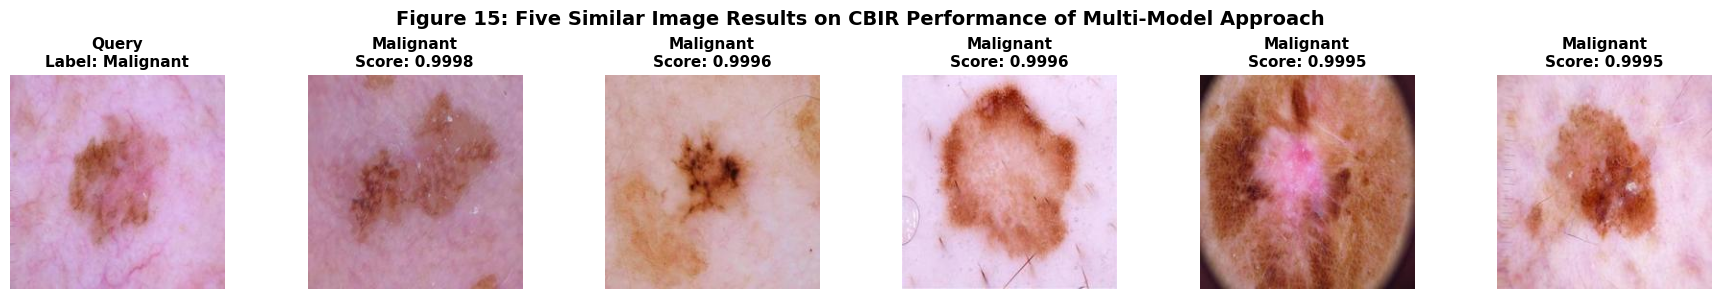

✓ Figure 15 saved



In [31]:
def visualize_cbir_top5_fusion(features, labels, filenames):
    """Visualize top-5 retrieval for fusion model"""
    
    np.random.seed(SEED + 20)
    query_idx = np.random.choice(len(features))
    
    query_feat = features[query_idx].reshape(1, -1)
    query_label = labels[query_idx]
    query_file = filenames[query_idx]
    
    similarities = cosine_similarity(query_feat, features)[0]
    sorted_indices = np.argsort(similarities)[::-1]
    sorted_indices = sorted_indices[sorted_indices != query_idx]
    top5_indices = sorted_indices[:5]
    
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))
    
    # Query image
    query_path = Config.TEST_DIR / query_file
    if query_path.exists():
        try:
            img = plt.imread(str(query_path))
            axes[0].imshow(img)
        except:
            axes[0].text(0.5, 0.5, 'Image Error', ha='center', va='center')
    
    axes[0].set_title(f'Query\nLabel: {Config.CLASSES[query_label]}',
                     fontsize=11, fontweight='bold')
    axes[0].axis('off')
    
    # Top-5 results
    for j, idx in enumerate(top5_indices):
        result_file = filenames[idx]
        result_label = labels[idx]
        similarity = similarities[idx]
        
        result_path = Config.TEST_DIR / result_file
        if result_path.exists():
            try:
                img = plt.imread(str(result_path))
                axes[j+1].imshow(img)
            except:
                axes[j+1].text(0.5, 0.5, 'Image Error', ha='center', va='center')
        
        axes[j+1].set_title(
            f'{Config.CLASSES[result_label]}\nScore: {similarity:.4f}',
            fontsize=11, fontweight='bold'
        )
        axes[j+1].axis('off')
    
    plt.suptitle('Figure 15: Five Similar Image Results on CBIR Performance of Multi-Model Approach', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(Config.FIGURES_DIR / 'figure_15_cbir_top5_fusion.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_cbir_top5_fusion(fused_features, cbir_labels, cbir_filenames)

print("✓ Figure 15 saved\n")

### SECTION 9: STATISTICAL VALIDATION

#### 9.1 Bootstrap Confidence Intervals

In [32]:
def bootstrap_metric(y_true, y_pred, metric_func, n_iterations=100):
    """Calculate bootstrap confidence intervals"""
    scores = []
    n_samples = len(y_true)
    
    for _ in range(n_iterations):
        indices = resample(range(n_samples), n_samples=n_samples)
        score = metric_func(y_true[indices], y_pred[indices])
        scores.append(score)
    
    scores = np.array(scores)
    mean = np.mean(scores)
    std = np.std(scores)
    ci_width = 1.96 * (std / np.sqrt(n_iterations))
    
    return {
        'mean': mean,
        'std': std,
        'ci_width': ci_width,
        'ci_lower': mean - ci_width,
        'ci_upper': mean + ci_width
    }

print("Calculating bootstrap CIs for accuracy...")

bootstrap_accuracy = {}

for name, res in evaluation_results.items():
    bootstrap_accuracy[name] = bootstrap_metric(
        res['y_true'], 
        res['y_pred'], 
        accuracy_score, 
        Config.BOOTSTRAP_ITERATIONS
    )

print("✓ Accuracy bootstrap complete\n")

Calculating bootstrap CIs for accuracy...
✓ Accuracy bootstrap complete



#### 9.2 Table 6: Accuracy Bootstrap CI

In [33]:
def generate_table_6():
    """Table 6: Accuracy with 95% Confidence Intervals"""
    
    data = {
        'Models': [],
        'Accuracy (%)': [],
        'Std (%)': [],
        'CI Width (±)': [],
        '95% CI Range': []
    }
    
    for name, boot in bootstrap_accuracy.items():
        data['Models'].append(name)
        data['Accuracy (%)'].append(f"{boot['mean']*100:.2f}%")
        data['Std (%)'].append(f"{boot['std']*100:.2f}")
        data['CI Width (±)'].append(f"±{boot['ci_width']:.3f}")
        data['95% CI Range'].append(
            f"({boot['ci_lower']:.2f}–{boot['ci_upper']:.2f})"
        )
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("TABLE 6: ACCURACY WITH 95% CI (n=100)")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80 + "\n")
    
    df.to_csv(Config.RESULTS_DIR / 'table_6_accuracy_ci.csv', index=False)
    
    return df

table_6 = generate_table_6()



TABLE 6: ACCURACY WITH 95% CI (n=100)
     Models Accuracy (%) Std (%) CI Width (±) 95% CI Range
DenseNet121       94.09%    0.47       ±0.001  (0.94–0.94)
InceptionV3       92.23%    0.66       ±0.001  (0.92–0.92)
   Xception       93.62%    0.52       ±0.001  (0.94–0.94)
        ViT       87.23%    0.77       ±0.002  (0.87–0.87)
   Ensemble       94.83%    0.56       ±0.001  (0.95–0.95)



#### 9.3 Bootstrap for CBIR mAP

In [34]:
def bootstrap_map(ap_scores, n_iterations=100):
    """Calculate bootstrap CI for mAP"""
    maps = []
    
    for _ in range(n_iterations):
        sample = resample(ap_scores, n_samples=len(ap_scores))
        maps.append(np.mean(sample))
    
    maps = np.array(maps)
    mean = np.mean(maps)
    std = np.std(maps)
    ci_width = 1.96 * (std / np.sqrt(n_iterations))
    
    return {
        'mean': mean,
        'std': std,
        'ci_width': ci_width,
        'ci_lower': mean - ci_width,
        'ci_upper': mean + ci_width
    }

print("Calculating bootstrap CIs for CBIR mAP...")

bootstrap_map_results = {}

for name, res in cbir_results.items():
    bootstrap_map_results[name] = bootstrap_map(
        res['ap_scores'], 
        Config.BOOTSTRAP_ITERATIONS
    )

bootstrap_map_results['Multi-model fusion'] = bootstrap_map(
    fusion_result['ap_scores'], 
    Config.BOOTSTRAP_ITERATIONS
)

print("✓ CBIR mAP bootstrap complete\n")

Calculating bootstrap CIs for CBIR mAP...
✓ CBIR mAP bootstrap complete



#### 9.4 Table 7: CBIR mAP Bootstrap CI

In [35]:
def generate_table_7():
    """Table 7: CBIR mAP with 95% Confidence Intervals"""
    
    data = {
        'Models': [],
        'mAP (%)': [],
        'Std (%)': [],
        'CI Width (±)': [],
        '95% CI Range': []
    }
    
    for name, boot in bootstrap_map_results.items():
        data['Models'].append(name)
        data['mAP (%)'].append(f"{boot['mean']:.4f}")
        data['Std (%)'].append(f"{boot['std']:.4f}")
        data['CI Width (±)'].append(f"±{boot['ci_width']:.6f}")
        data['95% CI Range'].append(
            f"({boot['ci_lower']:.4f}–{boot['ci_upper']:.4f})"
        )
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*80)
    print("TABLE 7: CBIR mAP WITH 95% CI (n=100)")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80 + "\n")

### SECTION 10: FINAL SUMMARY

In [36]:
print("\n" + "="*80)
print("COMPLETE FINAL RESULTS - CLASSIFICATION + CBIR")
print("="*80)


print("\n" + "─"*80)
print("CLASSIFICATION PERFORMANCE")
print("─"*80)

print("\nIndividual Models:")
for name, res in evaluation_results.items():
    if name != 'Ensemble':
        print(f"  {name:20s}: {res['accuracy']*100:.2f}%")

# Check if Ensemble exists
if 'Ensemble' in evaluation_results:
    ens = evaluation_results['Ensemble']
    print(f"\nEnsemble (Optimized):     {ens['accuracy']*100:.2f}%")
else:
    print("\n Ensemble results not available")
    ens = None


print("\n" + "─"*80)
print("CBIR PERFORMANCE")
print("─"*80)

print("\nIndividual Models:")
for name, res in cbir_results.items():
    print(f"  {name:20s}: mAP = {res['mAP']:.4f}")

print(f"\nMulti-model Fusion:       mAP = {fusion_result['mAP']:.4f}")


print("\n" + "─"*80)
print("BASELINE COMPARISON")
print("─"*80)

# Classification Baseline
print(f"\nClassification:")
print(f"  Baseline Target:  {Config.BASELINE_ACCURACY*100:.2f}%")

if ens is not None:
    print(f"  Our Ensemble:     {ens['accuracy']*100:.2f}%")
    
    if ens['accuracy'] >= Config.BASELINE_ACCURACY:
        diff = (ens['accuracy'] - Config.BASELINE_ACCURACY) * 100
        print(f"  Result: ✓✓✓ BEAT BASELINE by +{diff:.2f}%!")
    else:
        diff = (Config.BASELINE_ACCURACY - ens['accuracy']) * 100
        print(f"  Gap: -{diff:.2f}%")
else:
    print(f"  Our Ensemble:     N/A")

# CBIR Baseline
print(f"\nCBIR:")
print(f"  Baseline Target:  {Config.BASELINE_MAP:.4f}")
print(f"  Our Fusion:       {fusion_result['mAP']:.4f}")

if fusion_result['mAP'] >= Config.BASELINE_MAP:
    diff_map = fusion_result['mAP'] - Config.BASELINE_MAP
    print(f"  Result: ✓✓✓ BEAT BASELINE by +{diff_map:.4f}!")
else:
    diff_map = Config.BASELINE_MAP - fusion_result['mAP']
    print(f"  Gap: -{diff_map:.4f}")


print("\n" + "="*80)
print("ALL TABLES GENERATED")
print("="*80)
print("  ✓ Table 2: Transfer Learning Performance")
print("  ✓ Table 3: Ensemble Performance")
print("  ✓ Table 4: Individual CBIR mAP")
print("  ✓ Table 5: Multi-model Fusion CBIR mAP")
print("  ✓ Table 6: Accuracy Bootstrap CI")
print("  ✓ Table 7: CBIR mAP Bootstrap CI")


print("\n" + "="*80)
print("ALL FIGURES GENERATED")
print("="*80)
print("  ✓ Figure 2:  Dataset Distribution")
print("  ✓ Figure 9:  Confusion Matrices (Transfer Learning)")
print("  ✓ Figure 10: ROC Curves (Transfer Learning)")
print("  ✓ Figure 11: Ensemble CM + ROC")
print("  ✓ Figure 12: CBIR PR Curves (Individual Models)")
print("  ✓ Figure 13: CBIR Top-5 Results (Individual)")
print("  ✓ Figure 14: CBIR PR Curves (Multi-Model Fusion)")
print("  ✓ Figure 15: CBIR Top-5 Results (Fusion)")

print("\n" + "="*80)
print("EXPERIMENT COMPLETE!")
print("="*80)
print(f"\nAll results saved to: {Config.OUTPUT_DIR}")

# Training time summary
if 'training_times' in globals() and training_times:
    total_time = sum(training_times.values(), timedelta())
    print(f"\nTotal training time: {total_time}")
    print("\nTraining time breakdown:")
    for model_name, time_taken in training_times.items():
        print(f"  {model_name:20s}: {time_taken}")

print("\n" + "="*80)


summary_file = Config.RESULTS_DIR / 'experiment_summary.txt'

with open(summary_file, 'w') as f:
    f.write("="*80 + "\n")
    f.write("COMPLETE FINAL RESULTS - CLASSIFICATION + CBIR\n")
    f.write("="*80 + "\n\n")
    
    # Classification Results
    f.write("CLASSIFICATION PERFORMANCE\n")
    f.write("─"*80 + "\n\n")
    f.write("Individual Models:\n")
    for name, res in evaluation_results.items():
        if name != 'Ensemble':
            f.write(f"  {name:20s}: {res['accuracy']*100:.2f}%\n")
    
    if ens is not None:
        f.write(f"\nEnsemble (Optimized):     {ens['accuracy']*100:.2f}%\n")
    
    # CBIR Results
    f.write("\n" + "─"*80 + "\n")
    f.write("CBIR PERFORMANCE\n")
    f.write("─"*80 + "\n\n")
    f.write("Individual Models:\n")
    for name, res in cbir_results.items():
        f.write(f"  {name:20s}: mAP = {res['mAP']:.4f}\n")
    f.write(f"\nMulti-model Fusion:       mAP = {fusion_result['mAP']:.4f}\n")
    
    # Baseline Comparison
    f.write("\n" + "─"*80 + "\n")
    f.write("BASELINE COMPARISON\n")
    f.write("─"*80 + "\n\n")
    
    f.write(f"Classification:\n")
    f.write(f"  Baseline Target:  {Config.BASELINE_ACCURACY*100:.2f}%\n")
    if ens is not None:
        f.write(f"  Our Ensemble:     {ens['accuracy']*100:.2f}%\n")
        if ens['accuracy'] >= Config.BASELINE_ACCURACY:
            diff = (ens['accuracy'] - Config.BASELINE_ACCURACY) * 100
            f.write(f"  Result: ✓✓✓ BEAT BASELINE by +{diff:.2f}%!\n")
        else:
            diff = (Config.BASELINE_ACCURACY - ens['accuracy']) * 100
            f.write(f"  Gap: -{diff:.2f}%\n")
    
    f.write(f"\nCBIR:\n")
    f.write(f"  Baseline Target:  {Config.BASELINE_MAP:.4f}\n")
    f.write(f"  Our Fusion:       {fusion_result['mAP']:.4f}\n")
    if fusion_result['mAP'] >= Config.BASELINE_MAP:
        diff_map = fusion_result['mAP'] - Config.BASELINE_MAP
        f.write(f"  Result: ✓✓✓ BEAT BASELINE by +{diff_map:.4f}!\n")
    else:
        diff_map = Config.BASELINE_MAP - fusion_result['mAP']
        f.write(f"  Gap: -{diff_map:.4f}\n")
    
    # Training times
    if 'training_times' in globals() and training_times:
        f.write("\n" + "─"*80 + "\n")
        f.write("TRAINING TIME BREAKDOWN\n")
        f.write("─"*80 + "\n\n")
        for model_name, time_taken in training_times.items():
            f.write(f"  {model_name:20s}: {time_taken}\n")
        total_time = sum(training_times.values(), timedelta())
        f.write(f"\nTotal training time: {total_time}\n")
    
    f.write("\n" + "="*80 + "\n")

print(f"\n✓ Summary saved to: {summary_file.name}\n")


COMPLETE FINAL RESULTS - CLASSIFICATION + CBIR

────────────────────────────────────────────────────────────────────────────────
CLASSIFICATION PERFORMANCE
────────────────────────────────────────────────────────────────────────────────

Individual Models:
  DenseNet121         : 94.10%
  InceptionV3         : 92.25%
  Xception            : 93.65%
  ViT                 : 87.20%

Ensemble (Optimized):     94.80%

────────────────────────────────────────────────────────────────────────────────
CBIR PERFORMANCE
────────────────────────────────────────────────────────────────────────────────

Individual Models:
  DenseNet121         : mAP = 1.0000
  InceptionV3         : mAP = 0.9975
  Xception            : mAP = 0.9780
  ViT                 : mAP = 0.8819

Multi-model Fusion:       mAP = 0.9840

────────────────────────────────────────────────────────────────────────────────
BASELINE COMPARISON
────────────────────────────────────────────────────────────────────────────────

Classificati